<a href="https://colab.research.google.com/github/lauxpress/OH_VARIOS/blob/main/Scheihing_DatasetSeriesTemporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Presentacion de Dataset a utilizar - Lautaro Scheihing**

In [ ]:
import pandas as pd
import plotly.express as px
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox


In [ ]:
# Load data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv')
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head(10)

Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9
1956-06-01                     64.8
1956-07-01                     70.1
1956-08-01                     77.3
1956-09-01                     79.5
1956-10-01                    100.6

In [ ]:
# Load the CSV file into a pandas DataFrame
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)

# Display the dimensions of the DataFrame (rows x columns)
print(f"Dimensions of the DataFrame: {df.shape}")

# Display the first few rows of the DataFrame to understand the data structure
print("First few rows of the DataFrame:")
print(df.head())

# Display the data types of each column in the DataFrame
print("Data types of each column:")
print(df.dtypes)

# Display basic statistics about numerical columns (mean, min, max, etc.)
print("Basic statistics of numerical columns:")
print(df.describe())



Dimensions of the DataFrame: (476, 2)
First few rows of the DataFrame:
     Month  Monthly beer production
0  1956-01                     93.2
1  1956-02                     96.0
2  1956-03                     95.2
3  1956-04                     77.1
4  1956-05                     70.9
Data types of each column:
Month                       object
Monthly beer production    float64
dtype: object
Basic statistics of numerical columns:
       Monthly beer production
count               476.000000
mean                136.395378
std                  33.738725
min                  64.800000
25%                 112.900000
50%                 139.150000
75%                 158.825000
max                 217.800000


Por lo explicado anteriormente cambie la seleccion a este nuevo dataset que encontre en Kaggle que muestra la variacion de produccion cervecera mes a mes durante casi 50 años en Australia.

In [ ]:
fig = px.line(df, df.index, y='Monthly beer production', title='Produccion Cervecera Australiana')
fig.show()

#Observaciones

En este caso podemos resaltar varias caracteristicas que quedan en evidencia al observar la grafica. Tenemos un complortamiento ciclico que denota un consumo de cerveza elevado en los meses del verano Australiano (coincidente con el verano Argentino), teniendo su pico anual en el mes de Diciembre.
Se puede observar tambien un crecimiento en produccion a lo largo de los años traducido en una elevacion de los puntos medios del grafico.

Realizando las Rolling Statistics podemos apreciar de mejor manera este crecimiento de la media.

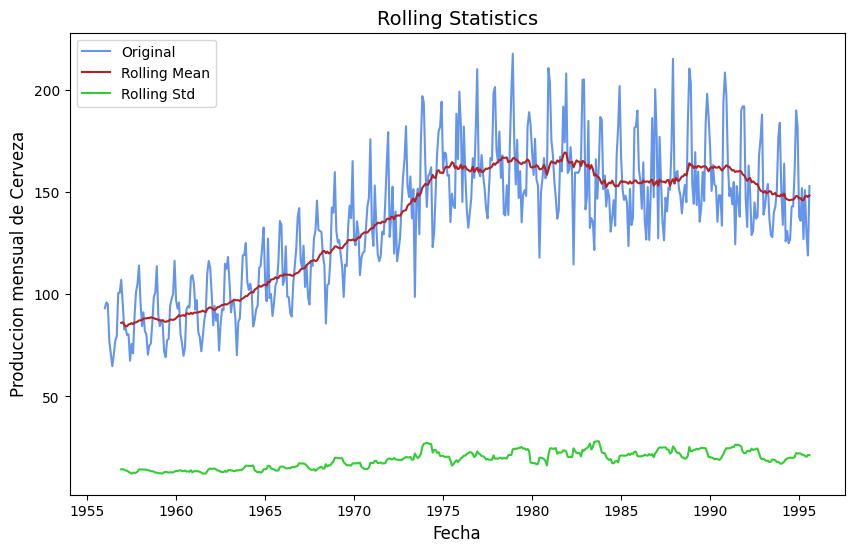

In [ ]:
import matplotlib.pyplot as plt
# Convertir la columna 'Fecha' a tipo datetime
df['Month'] = pd.to_datetime(df['Month'])

# Asegurarse de que la columna 'Produccion_mensual' sea numérica
df["Monthly beer production"] = pd.to_numeric(df["Monthly beer production"], errors='coerce')

# Calcular la media móvil y la desviación estándar
rolling_mean = df["Monthly beer production"].rolling(window=12).mean()
rolling_std =df["Monthly beer production"].rolling(window=12).std()

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(df['Month'], df["Monthly beer production"], color='cornflowerblue', label='Original')
plt.plot(df['Month'], rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(df['Month'], rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Fecha', size=12)
plt.ylabel('Produccion mensual de Cerveza', size=12)
plt.legend(loc='upper left')
plt.title('Rolling Statistics', size=14)
plt.show()


#Descomponer
Descomponemos la serie de tiempo utilizando el modelo aditivo.

In [ ]:
from matplotlib.pylab import rcParams

file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

rcParams['figure.figsize']=12,8
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

NameError: name 'seasonal_decompose' is not defined

#Evaluacion de Estacionareidad
Para esto utilizamos el kpss de la libreria de statsmodels
* Como podemos ver y quedaba en claro observando el grafico, esta es una serie de tiempo no estacionaria, por el upward trend que presenta. Ademas podemos agregar que la serie tiene una estacionalidad.

Podriamos forzar una estacionariedad seleccionando un intervalo de unos 10 a;os por ejemplo los primeros 10 desde 1955 a 1965.

In [ ]:
res = kpss(df['Monthly beer production'])
if res[1] < 0.05:
  print("TS no estacionaria (Rechaza hipotesis nula)")
else:
  print("TS estacionaria (No rechaza hipotesis nula)")


TS no estacionaria (Rechaza hipotesis nula)


<ipython-input-7-b451c574be38>:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




#ADFuller Test
Para decidir que modelo utilizar de mejor manera, vamos a realizar un test de Dickey-Fuller Aumentado.

In [ ]:
adfuller(df['Monthly beer production'])

(-2.282661418787577,
 0.17762099829132505,
 17,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 3463.9034375936567)

Se rechaza el test de Dickey - Fuller, lo que significa que no hay caminante aleatorio y por ende la serie diferenciada es estacionaria

#Extraer tendencia
Vamos a extraer la tendencia por el metodo de cuadrados minimos para casos ciclicos

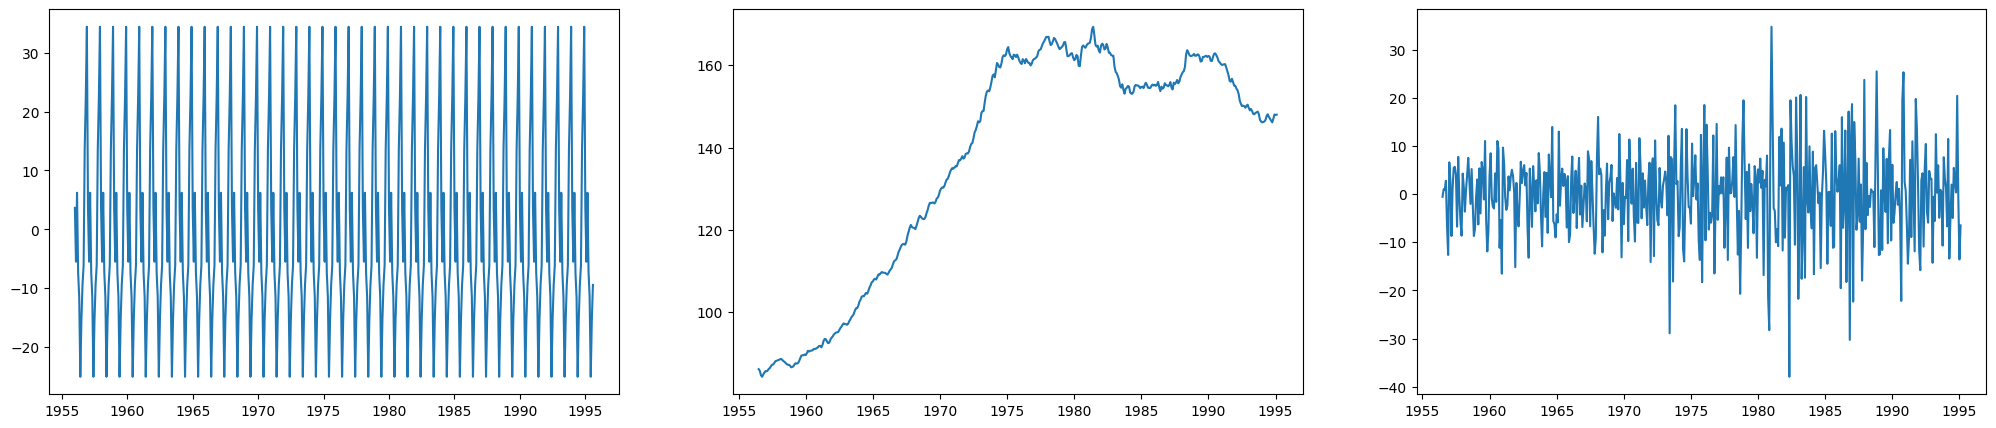

In [ ]:
plt.figure(figsize = (25,5))
a = seasonal_decompose(df["Monthly beer production"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(a.seasonal)

plt.subplot(1, 3, 2)
plt.plot(a.trend)

plt.subplot(1, 3, 3)
plt.plot(a.resid)

plt.show()

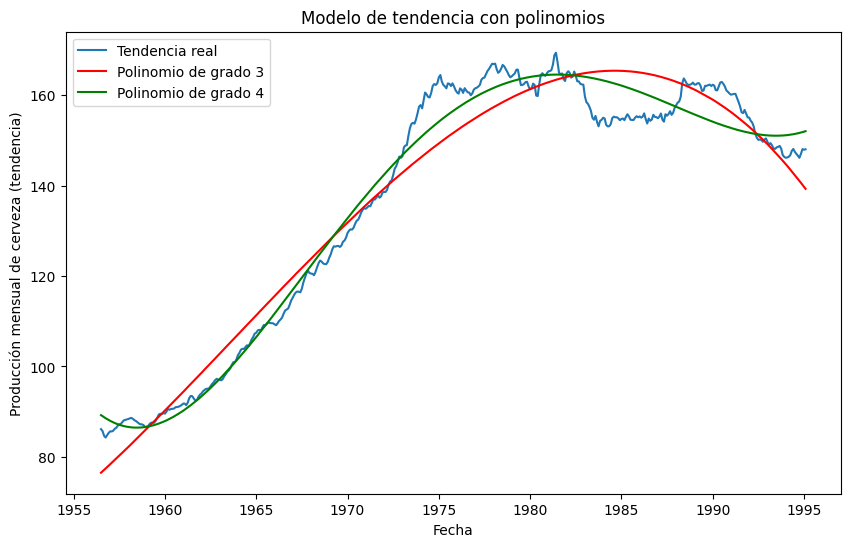

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Aplicar descomposición estacional
decomposition = seasonal_decompose(df["Monthly beer production"], model="add")

# Extraer la tendencia
trend = decomposition.trend.dropna()

# Ajustar polinomios de grado 3 y 4
poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(np.arange(len(trend)).reshape(-1, 1))
model_poly3 = LinearRegression().fit(X_poly3, trend)

poly4 = PolynomialFeatures(degree=4)
X_poly4 = poly4.fit_transform(np.arange(len(trend)).reshape(-1, 1))
model_poly4 = LinearRegression().fit(X_poly4, trend)

# Predecir valores para graficar la curva de tendencia
X_pred = np.arange(len(trend)).reshape(-1, 1)
X_pred_poly3 = poly3.transform(X_pred)
X_pred_poly4 = poly4.transform(X_pred)
y_pred_poly3 = model_poly3.predict(X_pred_poly3)
y_pred_poly4 = model_poly4.predict(X_pred_poly4)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(trend.index, trend.values, label='Tendencia real')
plt.plot(trend.index, y_pred_poly3, color='red', label='Polinomio de grado 3')
plt.plot(trend.index, y_pred_poly4, color='green', label='Polinomio de grado 4')
plt.xlabel('Fecha')
plt.ylabel('Producción mensual de cerveza (tendencia)')
plt.title('Modelo de tendencia con polinomios')
plt.legend()
plt.show()


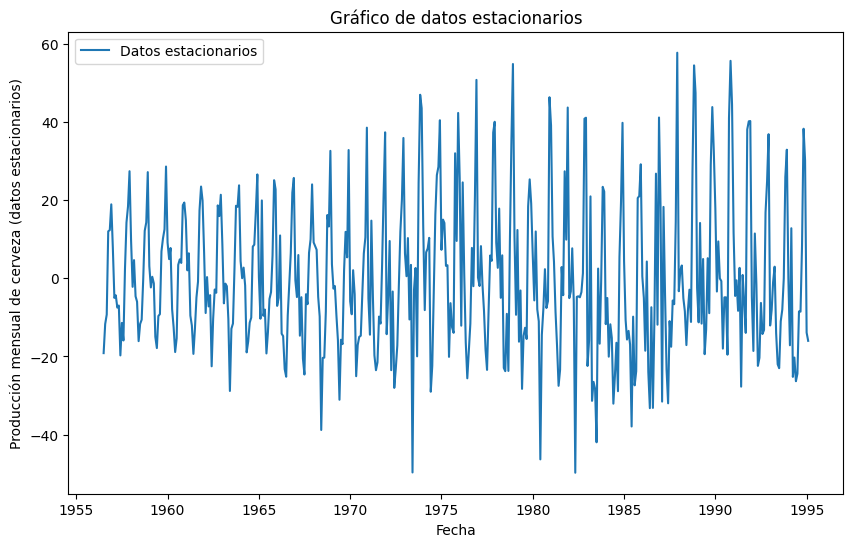

In [ ]:
# Ajustar polinomio de grado 4
poly4 = PolynomialFeatures(degree=4)
X_poly4 = poly4.fit_transform(np.arange(len(trend)).reshape(-1, 1))
model_poly4 = LinearRegression().fit(X_poly4, trend)
y_pred_poly4 = model_poly4.predict(X_poly4)

# Convertir y_pred_poly4 a una Serie de Pandas con el índice de trend
y_pred_poly4_series = pd.Series(y_pred_poly4, index=trend.index)

# Seleccionar un rango de fechas que coincida con los datos del polinomio ajustado
stationary_data_1 = df["Monthly beer production"].loc[y_pred_poly4_series.index[0]:y_pred_poly4_series.index[-1]] - y_pred_poly4_series

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(stationary_data_1.index, stationary_data_1.values, label='Datos estacionarios')
plt.xlabel('Fecha')
plt.ylabel('Producción mensual de cerveza (datos estacionarios)')
plt.title('Gráfico de datos estacionarios')
plt.legend()
plt.show()

# Evaluemos estacionariedad de la serie resultante
vamos a hacer lo mismo que antes y aplicaremos DF y KPSS

In [ ]:
res = kpss(stationary_data_1.values)
if res[1] < 0.05:
  print("TS no estacionaria (Rechaza hipotesis nula)")
else:
  print("TS estacionaria (No rechaza hipotesis nula)")


TS estacionaria (No rechaza hipotesis nula)


<ipython-input-12-32fc13d96e77>:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




#ADFuller Test
Para decidir que modelo utilizar de mejor manera, vamos a realizar un test de Dickey-Fuller Aumentado.

In [ ]:
adfuller(stationary_data_1.values)

(-2.1982771252530706,
 0.2068713551674824,
 17,
 446,
 {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893},
 3363.626343102177)

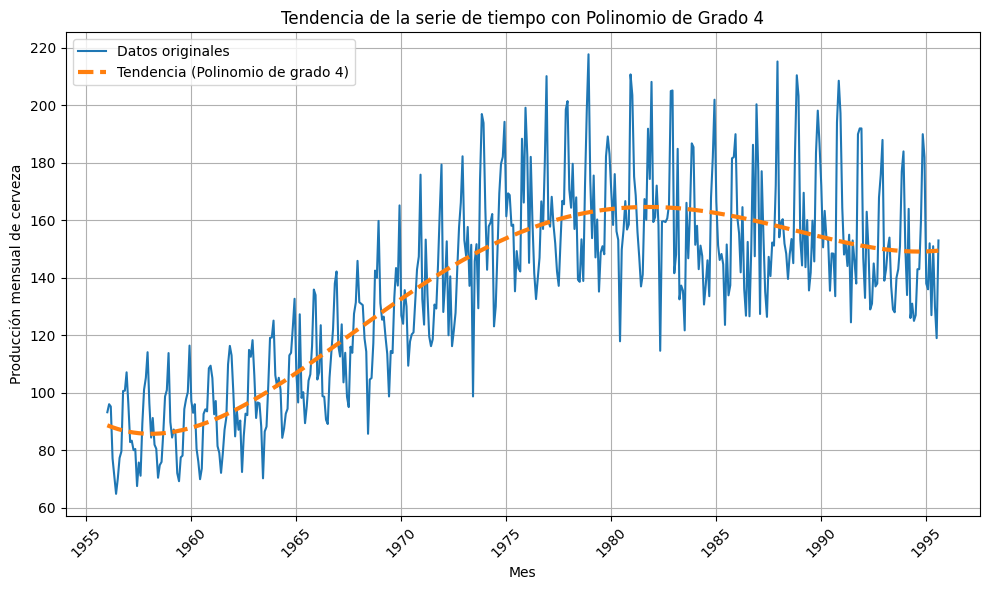

In [ ]:
# Definimos las variables
X = np.arange(len(df)).reshape(-1, 1)
y = df["Monthly beer production"].values.reshape(-1, 1)

# Creamos el obejeto PolynomialFeatures para generar características polinómicas de grado 4
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)

# Entrenamos el modelo de regresión lineal con esas características polinómicas
model = LinearRegression()
model.fit(X_poly, y)

# Predecimo los valores del polinomio con el modelo entrenado
y_pred_poly4 = model.predict(X_poly)

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, y, label='Datos originales')
plt.plot(df.index, y_pred_poly4, label='Tendencia (Polinomio de grado 4)', linestyle='--',linewidth=3)
plt.xlabel('Mes')
plt.ylabel('Producción mensual de cerveza')
plt.title('Tendencia de la serie de tiempo con Polinomio de Grado 4')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


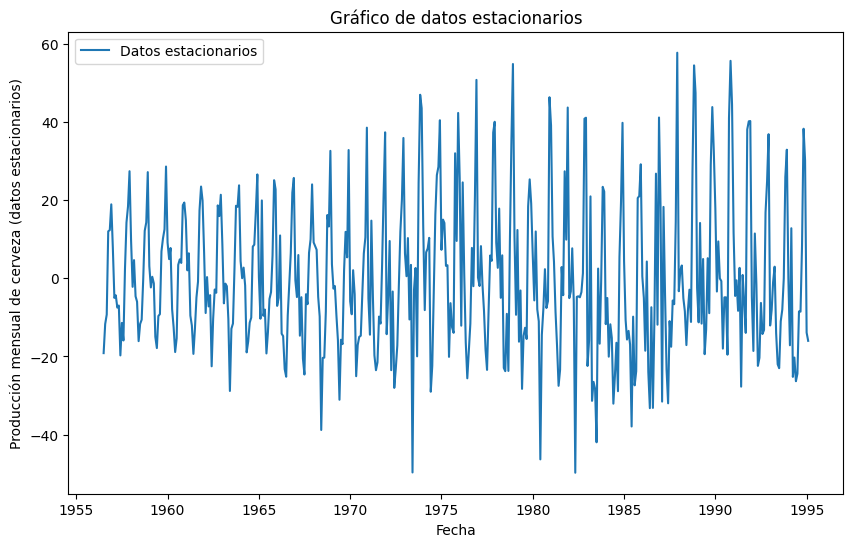

In [ ]:
# Seleccionar un rango de fechas que coincida con los datos del polinomio ajustado
stationary_data_2 = df["Monthly beer production"] - y_pred_poly4_series

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(stationary_data_2.index, stationary_data_2.values, label='Datos estacionarios')
plt.xlabel('Fecha')
plt.ylabel('Producción mensual de cerveza (datos estacionarios)')
plt.title('Gráfico de datos estacionarios')
plt.legend()
plt.show()

# Evaluemos estacionariedad de la serie resultante
vamos a hacer lo mismo que antes y aplicaremos DF y KPSS

In [ ]:
# Eliminar valores NaN e infinitos de la serie de tiempo
stationary_data_cleaned = stationary_data_2.dropna()
stationary_data_cleaned = stationary_data_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

# Realizar el test KPSS en la serie de tiempo limpia
res = kpss(stationary_data_cleaned.values)
if res[1] < 0.05:
    print("TS no estacionaria (Rechaza hipótesis nula)")
else:
    print("TS estacionaria (No rechaza hipótesis nula)")

TS estacionaria (No rechaza hipótesis nula)


<ipython-input-17-76e0a2223e0c>:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




#ADFuller Test
Para decidir que modelo utilizar de mejor manera, vamos a realizar un test de Dickey-Fuller Aumentado.
Busco rechazar el test de hipotesis.

In [ ]:
adfuller(stationary_data_cleaned.values)

(-2.1982771252530706,
 0.2068713551674824,
 17,
 446,
 {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893},
 3363.626343102177)

Se rechaza el test de Dickey - Fuller, lo que significa que no hay caminante aleatorio y por ende la serie es estacionaria

# Conclusion de estacionariedad:
Podemos ver que se obtuveron tanto por el metodo de modelar directamente la tendencia como modelar sobre la serie original, un polinimio de grado 4 que se ajusta casi perfectamente a nuestras necesidades. Luego de probar la estacionariedad de la resta de la serie original, con la tendencia aproximada con el test de KPSS tenemos como resultado que la serie es estacionaria y con el de Dickey Fuller Aumentado corroboramos que estamos en presencia de una serie estacionaria.

#Graficar la Autocorrelacion

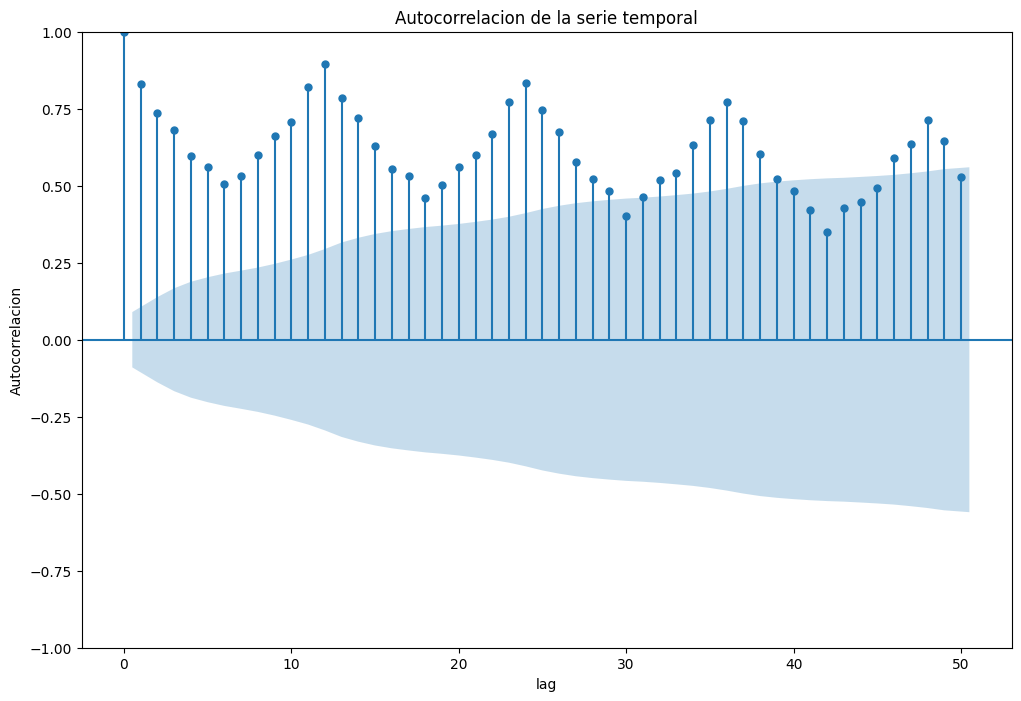

In [ ]:
plot_acf(df['Monthly beer production'], lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelacion')
plt.title('Autocorrelacion de la serie temporal')
plt.show()

<Figure size 1200x600 with 0 Axes>

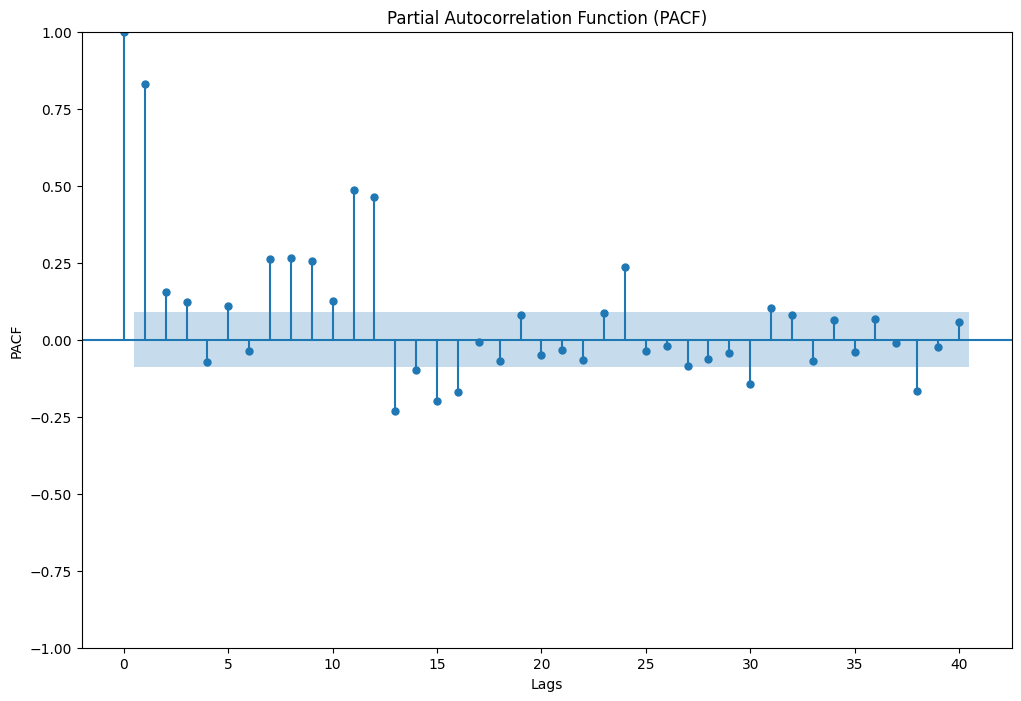

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Cargar los datos y convertir la columna 'Month' a tipo datetime
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])

# Graficar el PACF de la serie temporal
plt.figure(figsize=(12, 6))
plot_pacf(df["Monthly beer production"], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()


El orden del modelo MA se define como la cantidad de lags que estan por encima de la zona azul.

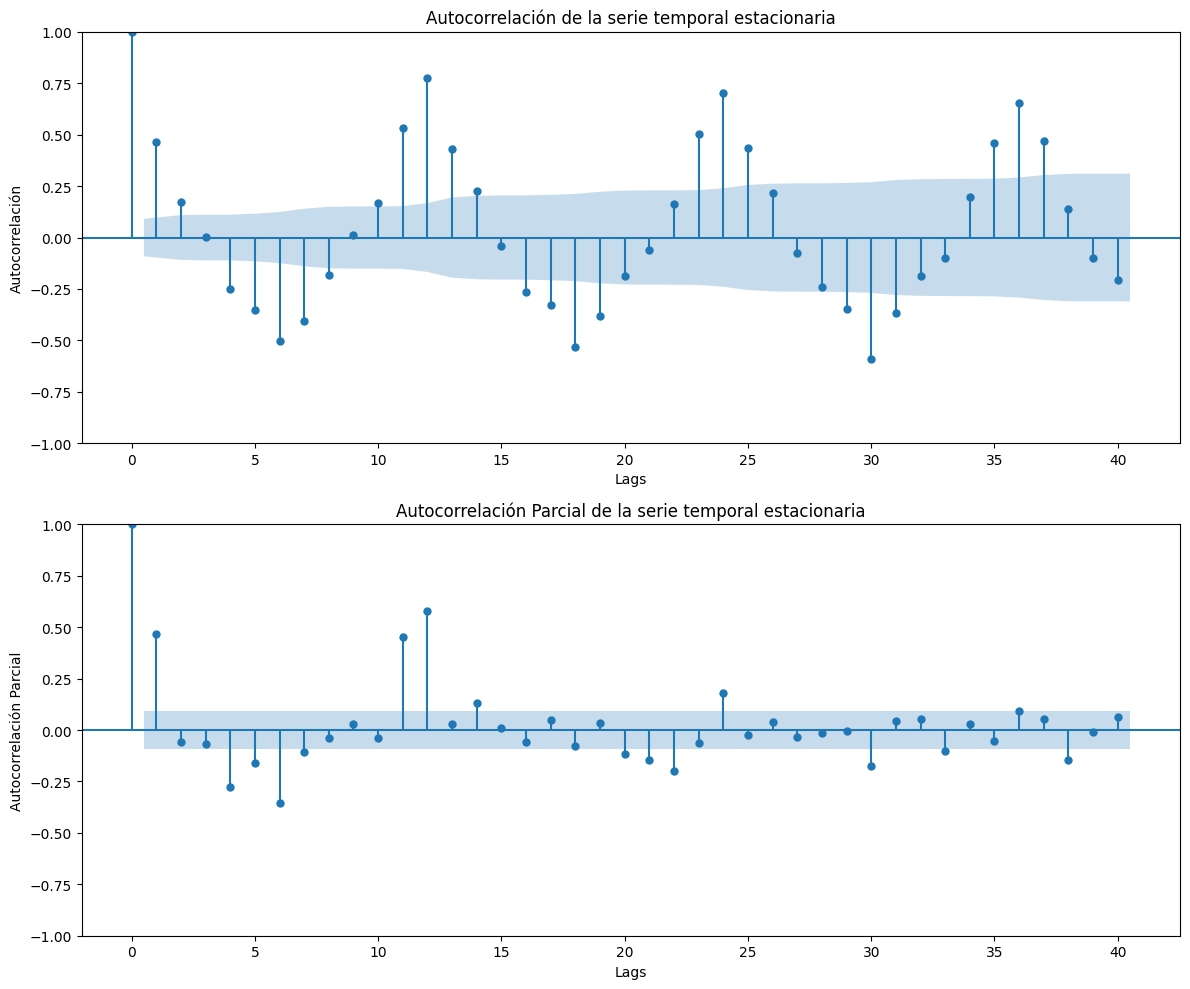

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Cargar los datos y convertir la columna 'Month' a tipo datetime
df = stationary_data_cleaned

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Graficar el ACF en el primer subplot
plot_acf(df.values, lags=40, ax=ax1)
ax1.set_title('Autocorrelación de la serie temporal estacionaria')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelación')

# Graficar el PACF en el segundo subplot
plot_pacf(df.values, lags=40, ax=ax2)
ax2.set_title('Autocorrelación Parcial de la serie temporal estacionaria')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación Parcial')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


Autocorrelacion - MA
Autocorrelacion Parcial - AR

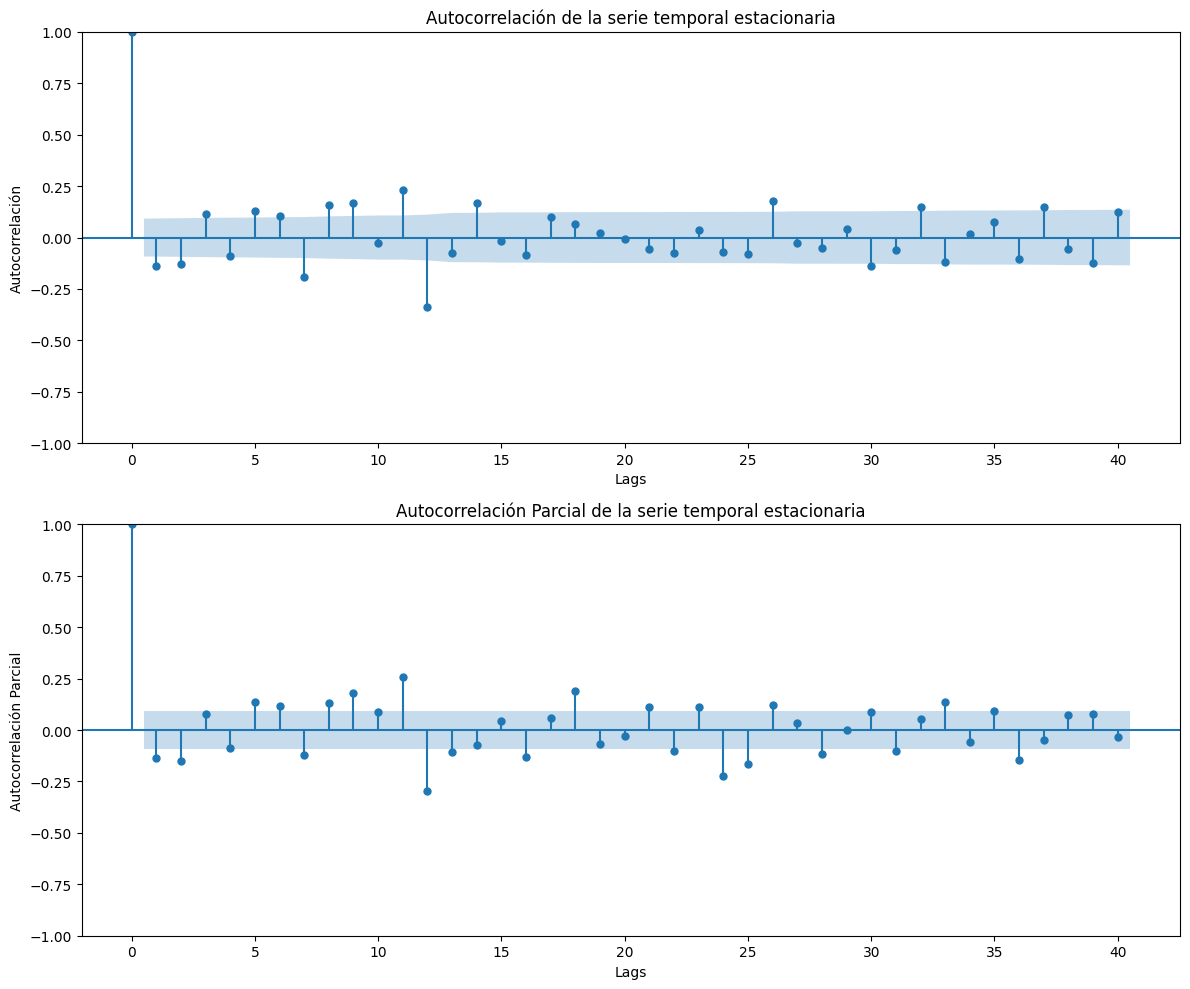

In [ ]:
# Perform differencing after converting to datetime
df = stationary_data_cleaned.diff(12)
# Drop NaN values created by differencing and select relevant data
df = df.dropna().reset_index(drop=True)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the ACF in the first subplot
plot_acf(df, lags=40, ax=ax1)
ax1.set_title('Autocorrelación de la serie temporal estacionaria')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelación')

# Plot the PACF in the second subplot
plot_pacf(df, lags=40, ax=ax2)
ax2.set_title('Autocorrelación Parcial de la serie temporal estacionaria')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelación Parcial')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

# Estimacion de los valores de orden de modelo ARIMA por medio de la herramienta de statmodels

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
data = df["Monthly beer production"]

# Definir rangos para los órdenes AR, MA y SARIMA
p_range = range(0, 3)  # Órdenes AR (0-2)
d_range = range(0, 2)  # Órdenes de diferenciación (0-1)
q_range = range(0, 3)  # Órdenes MA (0-2)
P_range = range(0, 3)  # Órdenes AR estacional (0-2)
D_range = range(0, 2)  # Órdenes de diferenciación estacional (0-1)
Q_range = range(0, 3)  # Órdenes MA estacional (0-2)

# Buscar los mejores órdenes utilizando AIC y BIC
results_aic = arma_order_select_ic(data, max_ar=max(p_range), max_ma=max(q_range), ic='aic')
results_bic = arma_order_select_ic(data, max_ar=max(p_range), max_ma=max(q_range), ic='bic')

print("Resultados de AIC:")
print(results_aic)
print("\nResultados de BIC:")
print(results_bic)

best_aic_order = results_aic['aic_min_order']
best_bic_order = results_bic['bic_min_order']

print("\nMejor orden según AIC:", best_aic_order)
print("Mejor orden según BIC:", best_bic_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Resultados de AIC:
{'aic':              0            1            2
0  4703.579691  4385.537158  4318.083484
1  4150.064624  4136.733370  4088.223212
2  4140.229294  4077.716415  4125.886426, 'aic_min_order': (2, 1)}

Resultados de BIC:
{'bic':              0            1            2
0  4711.910526  4398.033412  4334.745156
1  4162.560877  4153.395041  4109.050301
2  4156.890965  4098.543504  4150.878933, 'bic_min_order': (2, 1)}

Mejor orden según AIC: (2, 1)
Mejor orden según BIC: (2, 1)


# **Definamos el modelo ARIMA**
En este caso utilizaremos un seasonal ARIMA

# **ITERACION 1**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#Definimos el train y test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

#Definimos el modelo
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,3), seasonal_order = (1,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -1646.559
Date:                              Fri, 19 Apr 2024   AIC                           3309.118
Time:                                      22:55:41   BIC                           3342.010
Sample:                                  01-01-1956   HQIC                          3322.081
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1475      0.010   -115.411      0.000      -1.167      -1.128
ar.L2         -0.9836      0.010    -99.734      0.000      -1.003      -0.964
ma.L1          0.2185      0.031      7.044      0.000       0.158       0.279
ma.L2         -0.0231      0.032     -0.715      0.474      -0.086       0.040
ma.L3         -0.8355      0.029    -28.594      0.000      -0.893      -0.778
ar.S.L12       0.0041      0.054      0.075      0.940      -0.101       0.109
ma.S.L12      -0.8168      0.037    -22.162      0.000      -0.889      -0.745
sigma2        83.7882      4.578     18.302      0.000      74.815      92.761
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                46.14
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               4.15   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Ahora generamos una prediccion:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



1994-09-01    133.448053
1994-10-01    159.255277
1994-11-01    180.461168
1994-12-01    182.654286
1995-01-01    142.824862
1995-02-01    139.304984
1995-03-01    148.467689
1995-04-01    134.681053
1995-05-01    136.304265
1995-06-01    117.072779
1995-07-01    129.855747
1995-08-01    139.329303
Freq: MS, Name: ARIMA Predictions, dtype: float64

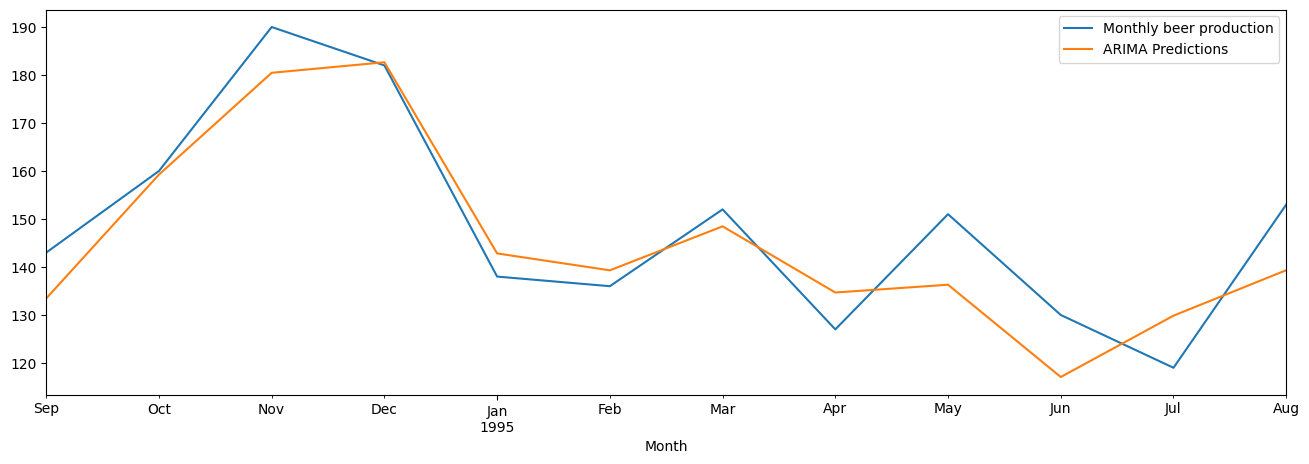

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

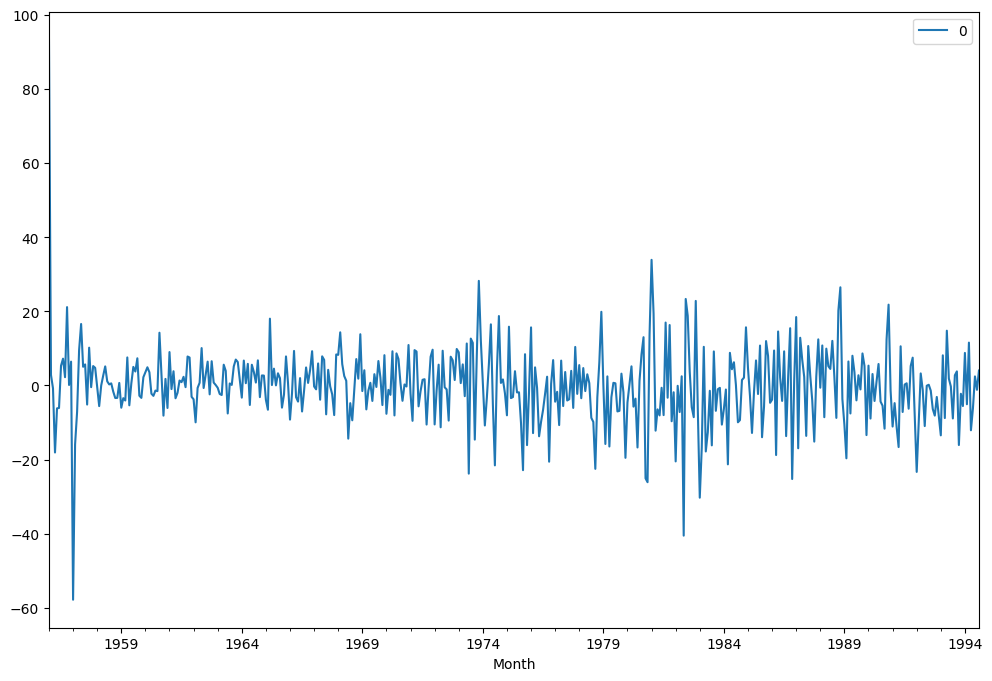

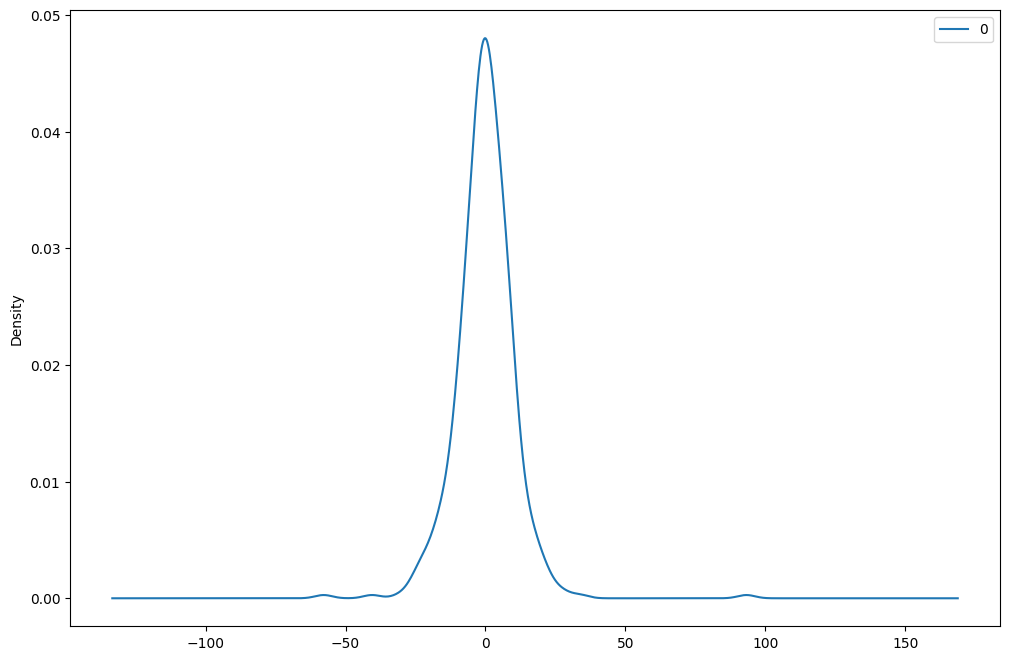

                0
count  464.000000
mean    -0.113406
std     10.534674
min    -57.800880
25%     -5.405319
50%      0.084245
75%      5.486634
max     93.200000


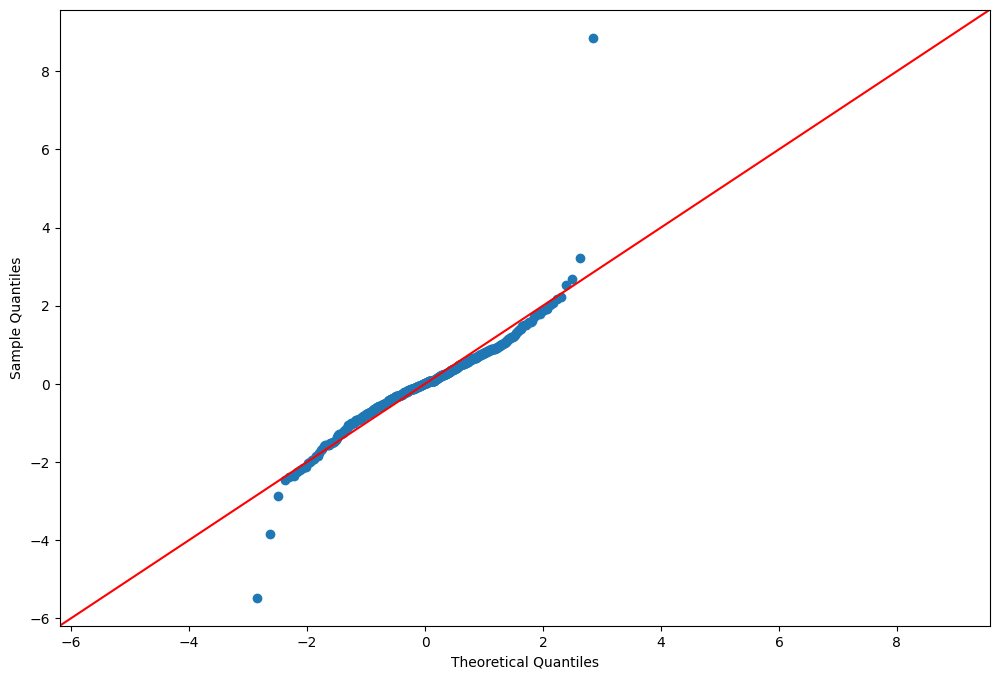

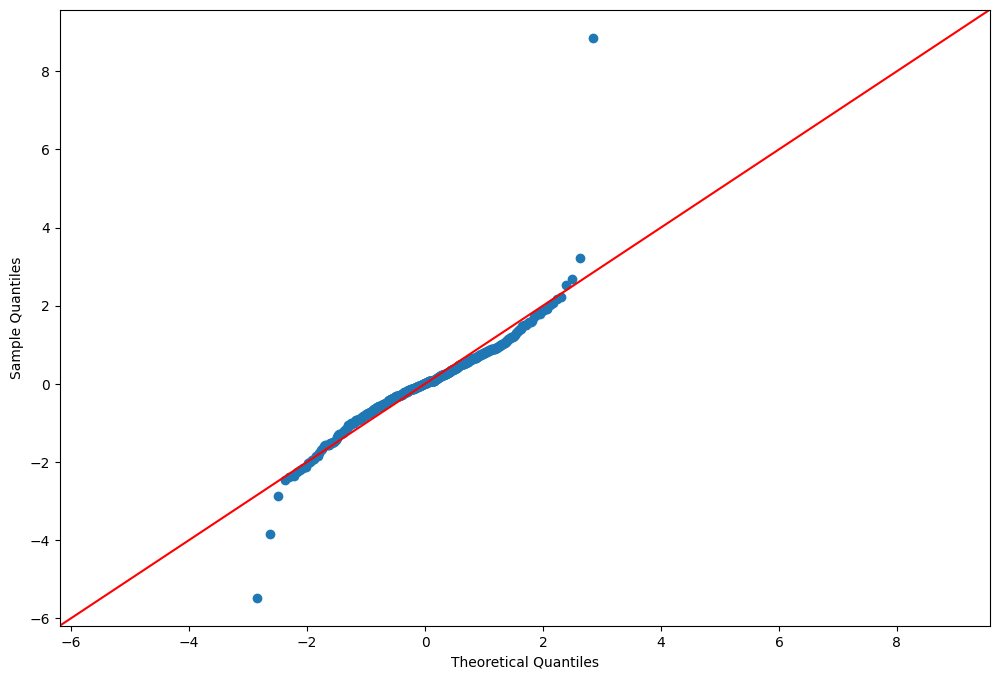

In [ ]:
# line plot of residuals
residuals = DataFrame(arima_result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

import statsmodels.api as sm

resid = arima_result.resid
sm.qqplot((resid-resid.mean())/resid.std(), line="45")

# **ITERACION 2**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#Definimos el train y test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

#Definimos el modelo
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,1), seasonal_order = (1,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1674.245
Date:                            Fri, 19 Apr 2024   AIC                           3360.489
Time:                                    22:55:45   BIC                           3385.158
Sample:                                01-01-1956   HQIC                          3370.211
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2293      0.039     -5.852      0.000      -0.306      -0.153
ar.L2         -0.2226      0.045     -4.964      0.000      -0.311      -0.135
ma.L1         -0.8463      0.026    -33.018      0.000      -0.897      -0.796
ar.S.L12       0.1339      0.056      2.409      0.016       0.025       0.243
ma.S.L12      -0.8681      0.032    -27.366      0.000      -0.930      -0.806
sigma2        94.6911      5.005     18.919      0.000      84.881     104.501
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                47.62
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.00   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Ahora generamos una prediccion:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



1994-09-01    134.482504
1994-10-01    159.282637
1994-11-01    174.933709
1994-12-01    183.995528
1995-01-01    147.167300
1995-02-01    135.201801
1995-03-01    152.679442
1995-04-01    135.212257
1995-05-01    131.684285
1995-06-01    120.728723
1995-07-01    129.938249
1995-08-01    136.283075
Freq: MS, Name: ARIMA Predictions, dtype: float64

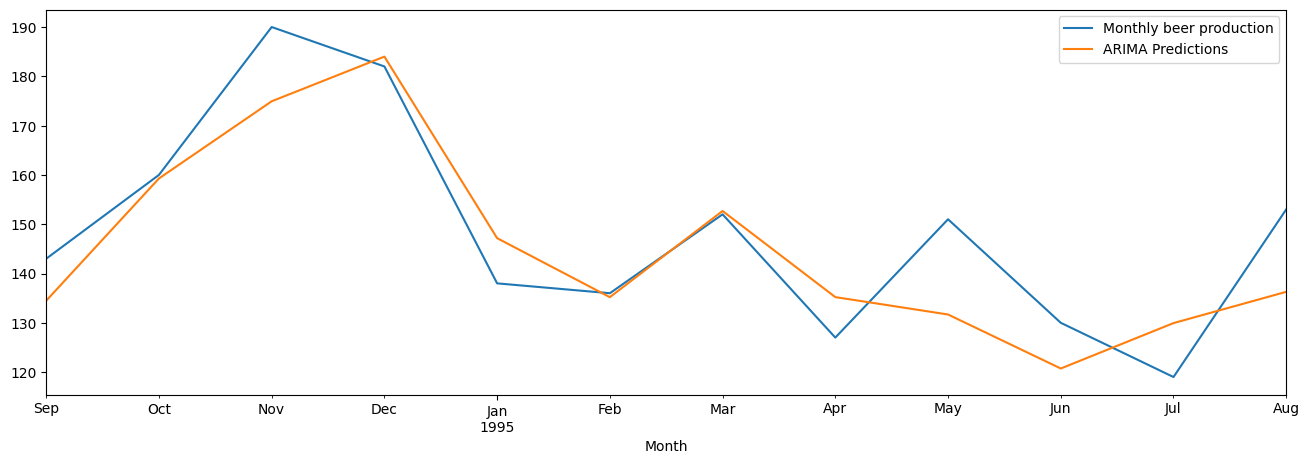

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

vemos que los resultados obtenidos son muy buenos y que este modelo puede ser utilizado para predecir con un grado de confianza alto el comportamiento futuro de la serie.

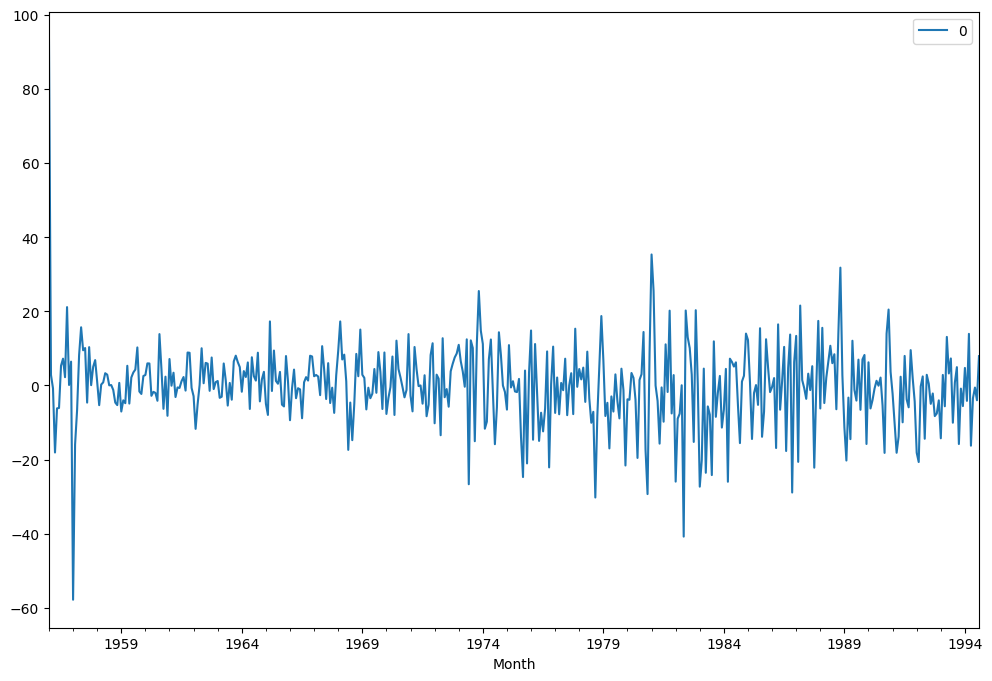

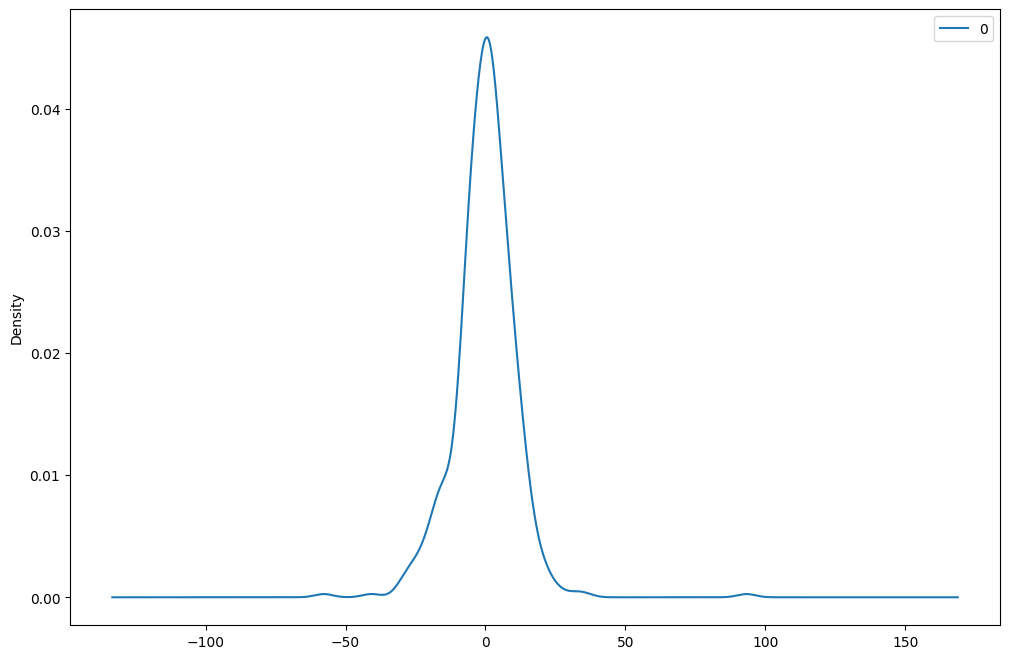

                0
count  464.000000
mean    -0.139217
std     11.038925
min    -57.800895
25%     -5.287836
50%      0.111033
75%      5.941268
max     93.200000


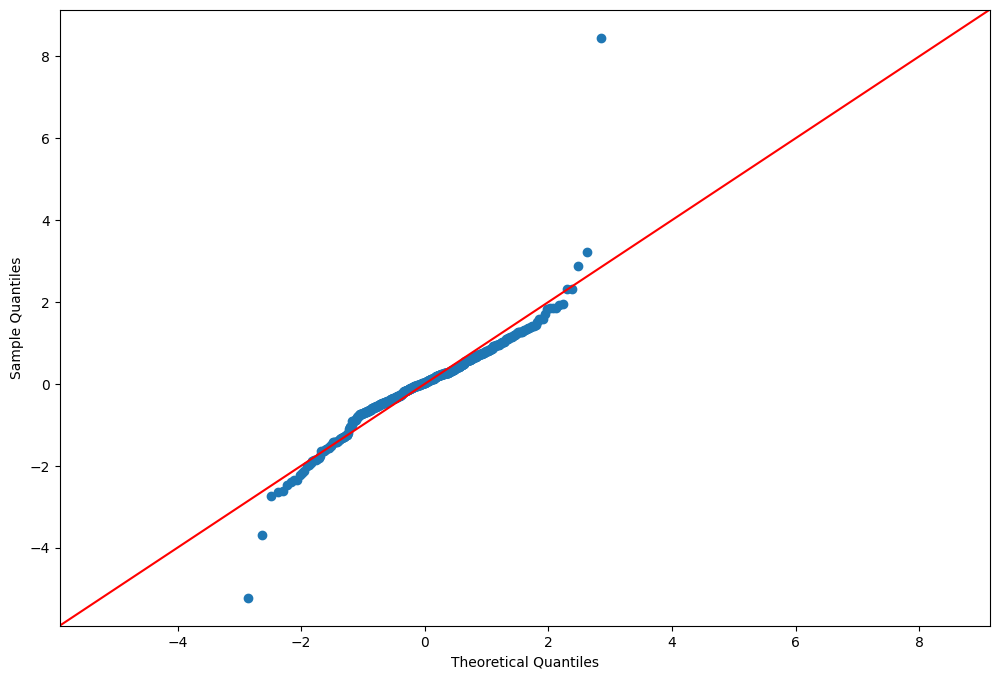

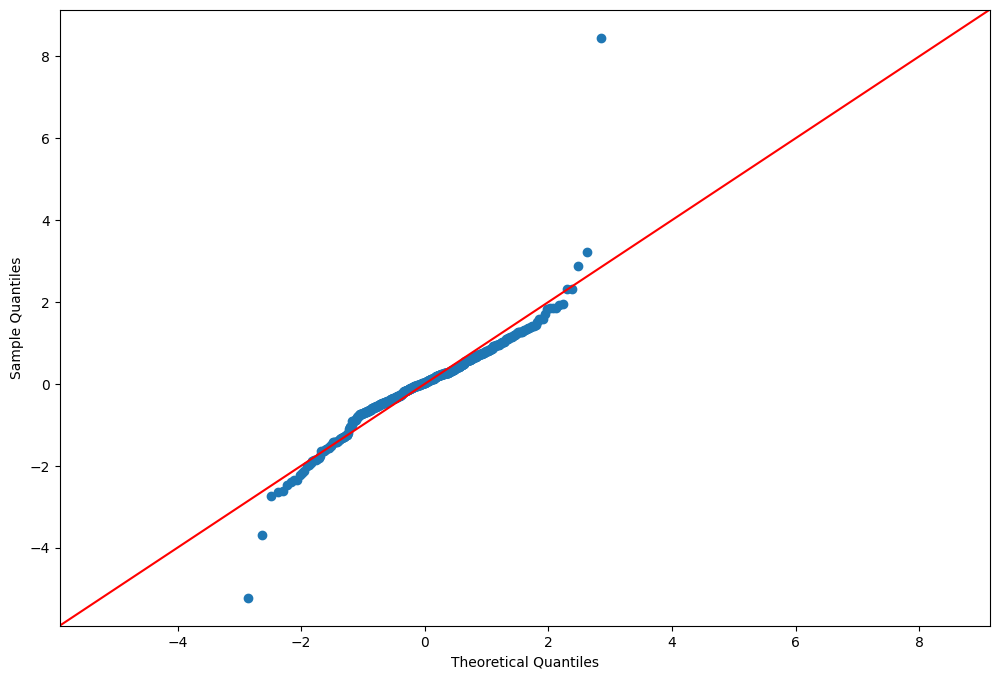

In [ ]:
# line plot of residuals
residuals = DataFrame(arima_result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

import statsmodels.api as sm

resid = arima_result.resid
sm.qqplot((resid-resid.mean())/resid.std(), line="45")

# **ITERACION 3**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#Definimos el train y test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

#Definimos el modelo
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,2), seasonal_order = (1,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1671.459
Date:                              Fri, 19 Apr 2024   AIC                           3356.919
Time:                                      22:55:51   BIC                           3385.699
Sample:                                  01-01-1956   HQIC                          3368.261
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6806      0.130     -5.229      0.000      -0.936      -0.426
ar.L2         -0.2942      0.040     -7.408      0.000      -0.372      -0.216
ma.L1         -0.3691      0.131     -2.824      0.005      -0.625      -0.113
ma.L2         -0.4225      0.123     -3.432      0.001      -0.664      -0.181
ar.S.L12       0.1153      0.054      2.125      0.034       0.009       0.222
ma.S.L12      -0.8614      0.032    -26.608      0.000      -0.925      -0.798
sigma2        93.5516      5.009     18.675      0.000      83.733     103.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                53.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Ahora generamos una prediccion:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



1994-09-01    134.386031
1994-10-01    159.415974
1994-11-01    176.061427
1994-12-01    183.496683
1995-01-01    147.081479
1995-02-01    135.376136
1995-03-01    152.345705
1995-04-01    135.489825
1995-05-01    131.769778
1995-06-01    120.720747
1995-07-01    130.099164
1995-08-01    136.191361
Freq: MS, Name: ARIMA Predictions, dtype: float64

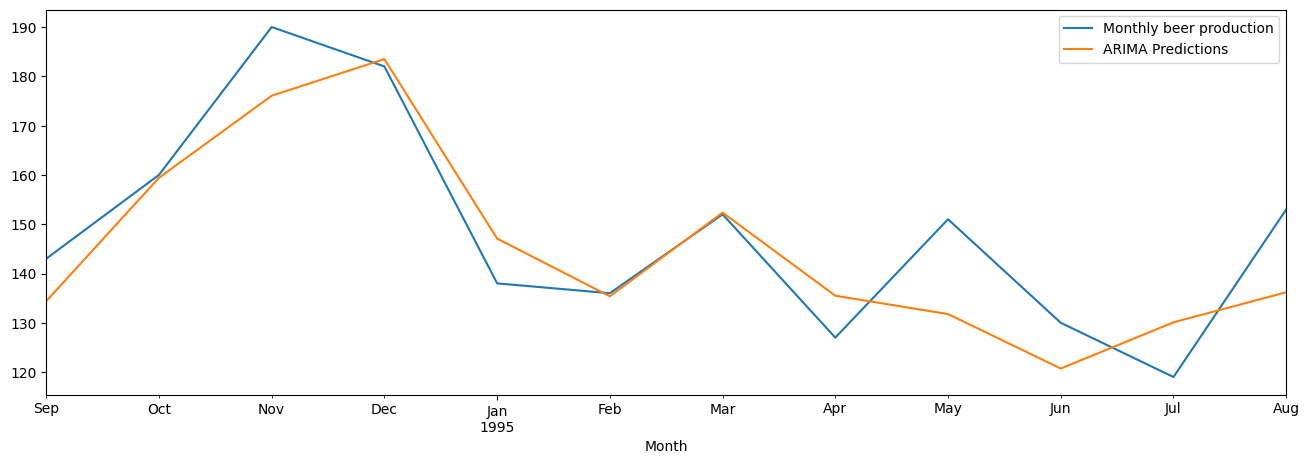

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

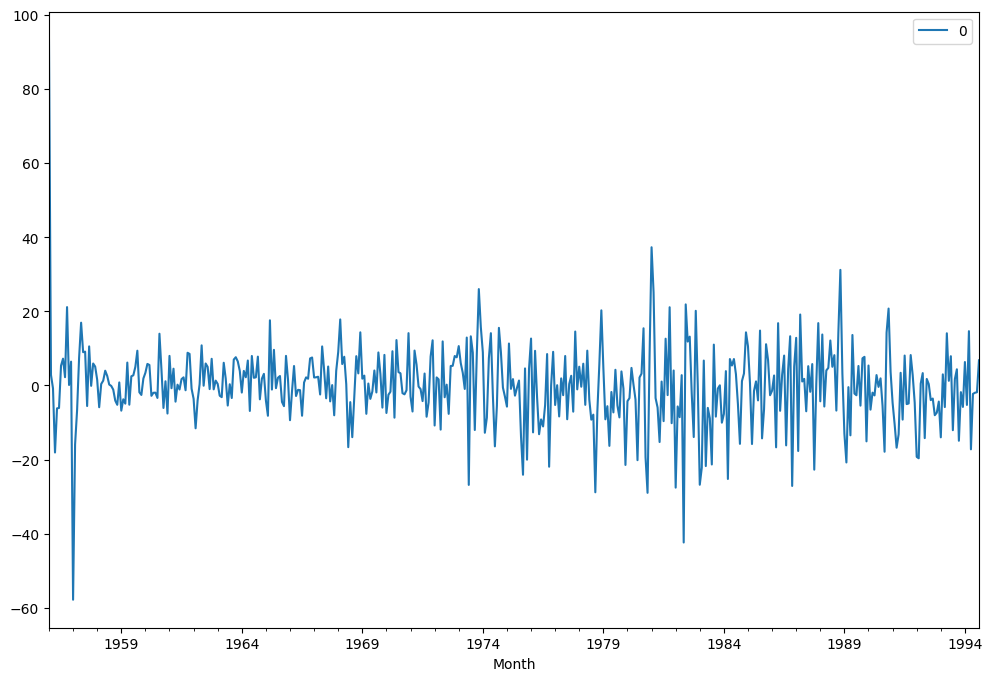

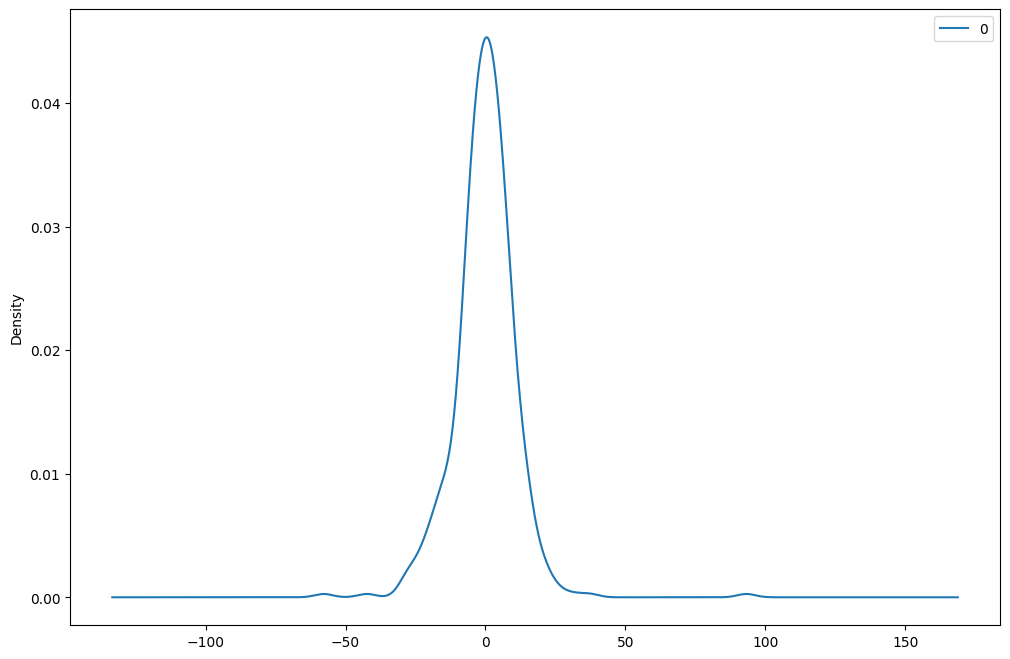

                0
count  464.000000
mean    -0.139111
std     10.988197
min    -57.801387
25%     -5.425803
50%      0.217808
75%      5.690988
max     93.200000


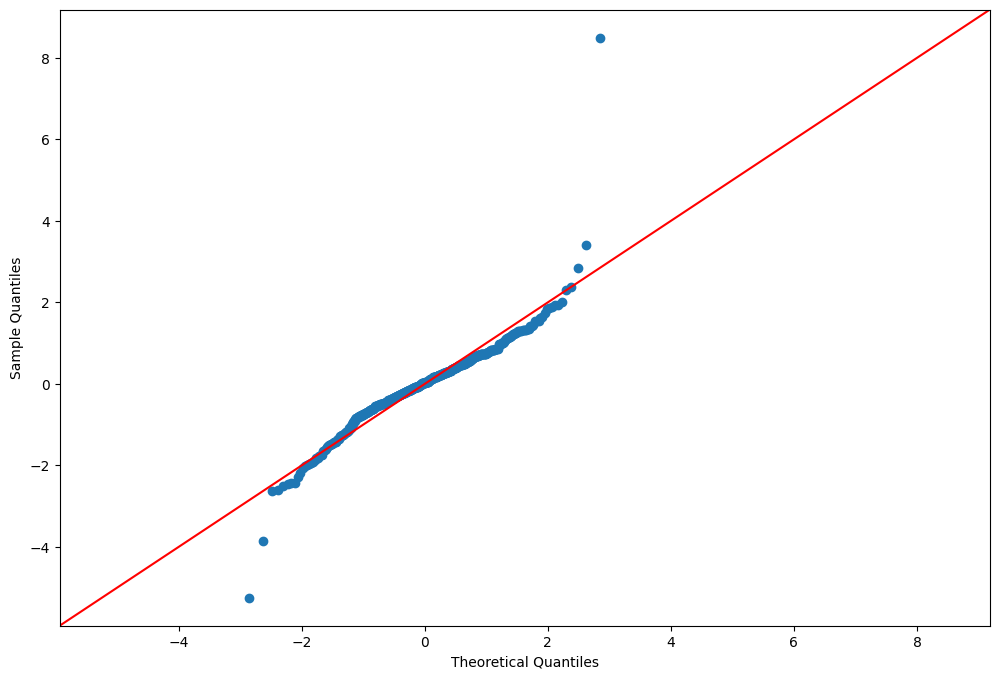

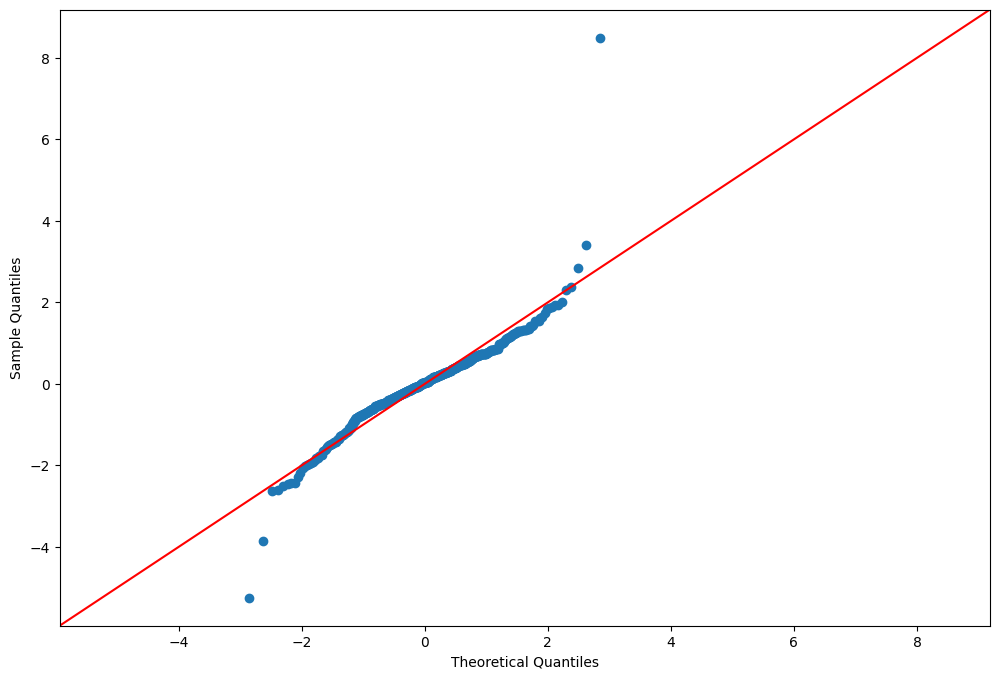

In [ ]:
# line plot of residuals
residuals = DataFrame(arima_result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

import statsmodels.api as sm

resid = arima_result.resid
sm.qqplot((resid-resid.mean())/resid.std(), line="45")

# **ITERACION 4**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#Definimos el train y test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

#Definimos el modelo
arima_model = SARIMAX(train_data['Monthly beer production'], order = (3,1,2), seasonal_order = (1,1,1,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                  464
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1671.458
Date:                              Fri, 19 Apr 2024   AIC                           3358.916
Time:                                      22:55:57   BIC                           3391.808
Sample:                                  01-01-1956   HQIC                          3371.879
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6877      0.323     -2.131      0.033      -1.320      -0.055
ar.L2         -0.2973      0.110     -2.704      0.007      -0.513      -0.082
ar.L3         -0.0037      0.111     -0.034      0.973      -0.222       0.214
ma.L1         -0.3626      0.307     -1.181      0.238      -0.964       0.239
ma.L2         -0.4275      0.244     -1.751      0.080      -0.906       0.051
ar.S.L12       0.1156      0.055      2.121      0.034       0.009       0.222
ma.S.L12      -0.8615      0.032    -26.551      0.000      -0.925      -0.798
sigma2        93.5476      5.044     18.547      0.000      83.662     103.433
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                53.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Ahora generamos una prediccion:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



1994-09-01    134.371229
1994-10-01    159.414265
1994-11-01    176.039373
1994-12-01    183.496885
1995-01-01    147.086370
1995-02-01    135.365033
1995-03-01    152.350995
1995-04-01    135.481511
1995-05-01    131.763775
1995-06-01    120.718931
1995-07-01    130.092721
1995-08-01    136.189939
Freq: MS, Name: ARIMA Predictions, dtype: float64

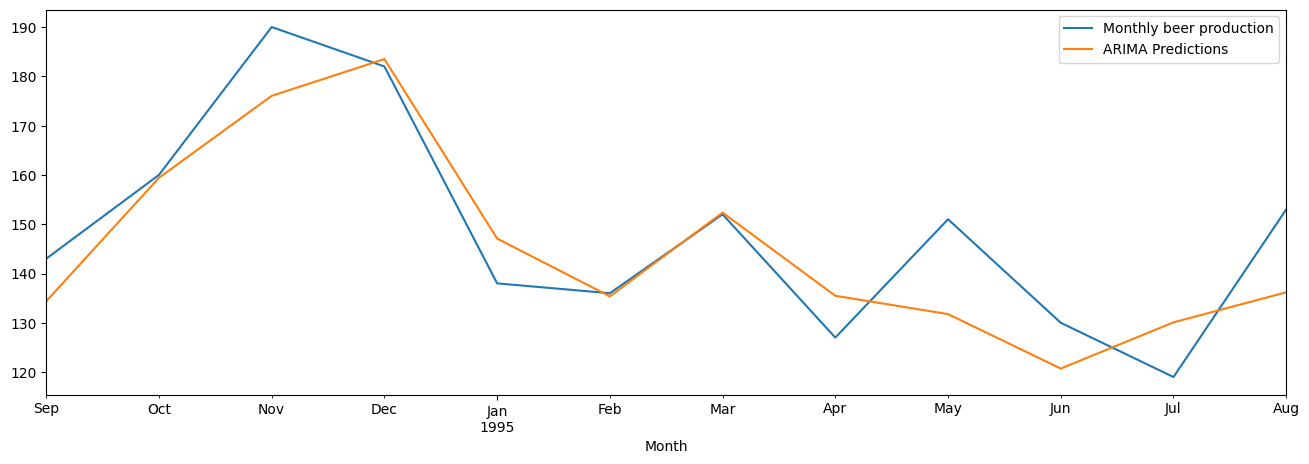

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

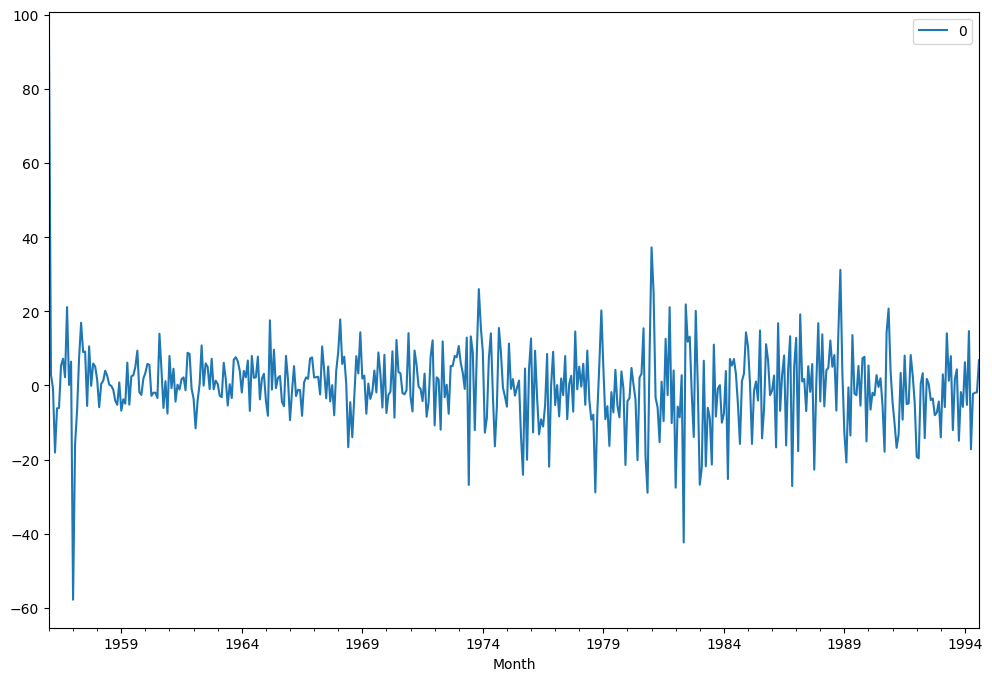

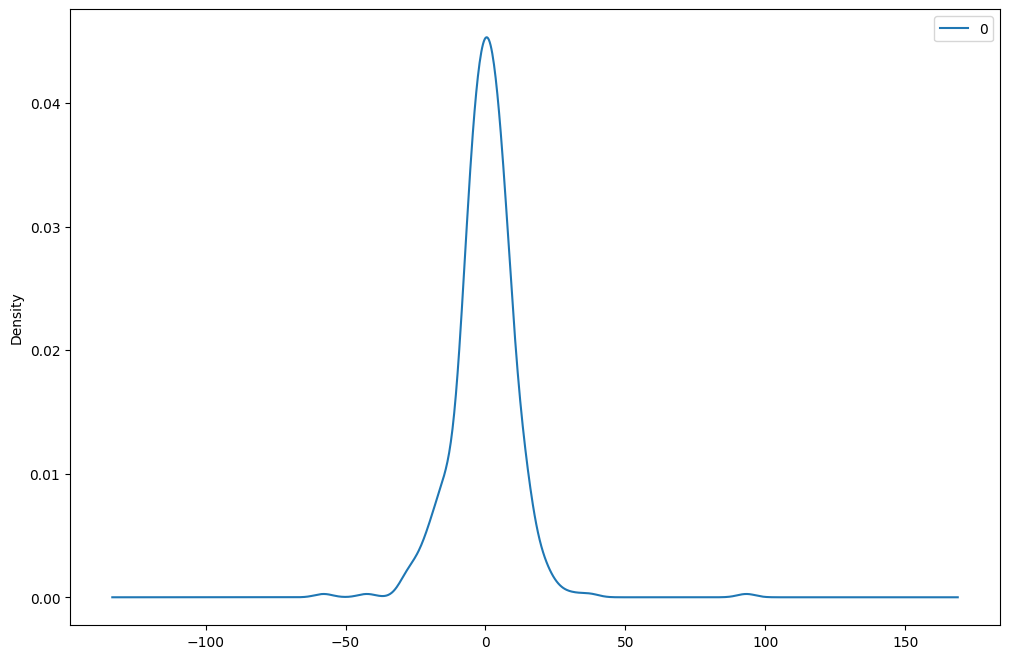

                0
count  464.000000
mean    -0.138994
std     10.988177
min    -57.801383
25%     -5.416121
50%      0.232997
75%      5.674263
max     93.200000


In [ ]:
# line plot of residuals
residuals = DataFrame(arima_result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


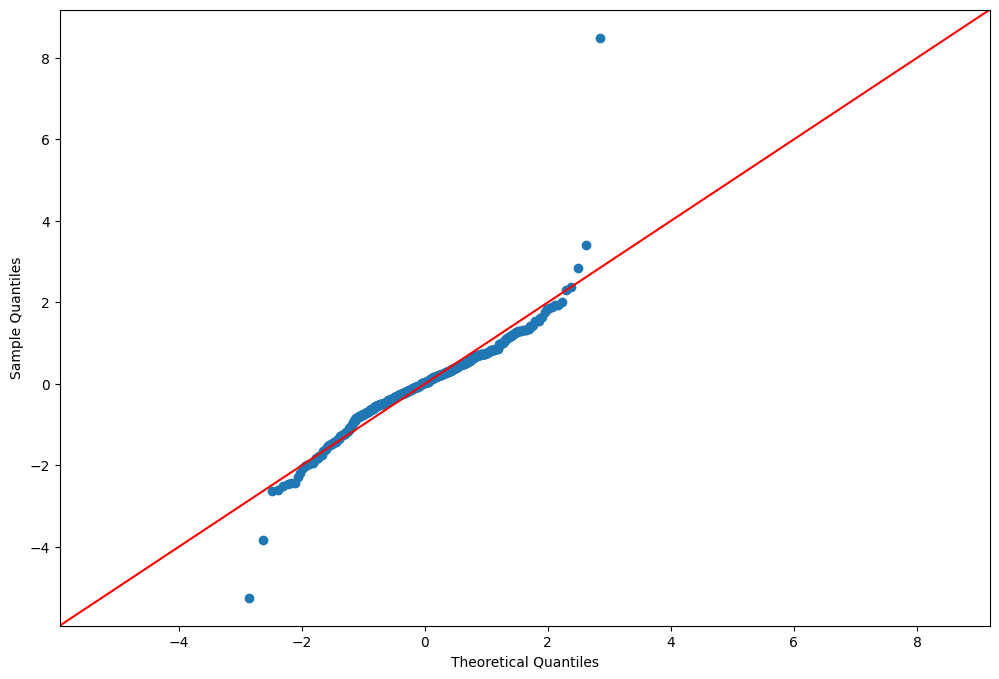

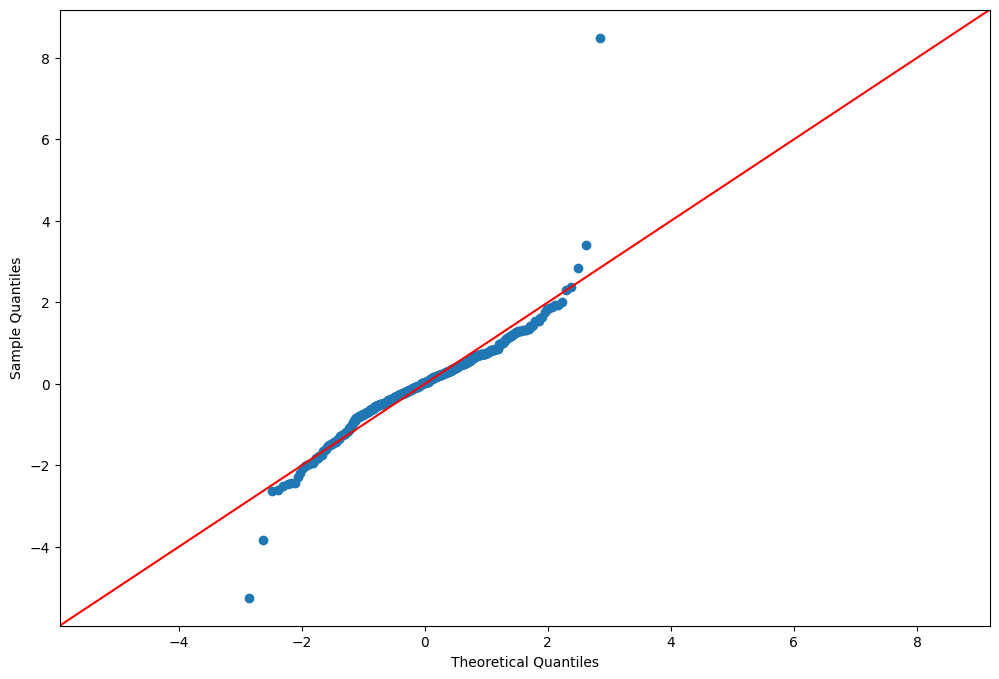

In [ ]:
import statsmodels.api as sm

resid = arima_result.resid
sm.qqplot((resid-resid.mean())/resid.std(), line="45")

# ITERACION 5

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#Definimos el train y test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

#Definimos el modelo
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,3), seasonal_order = (2,1,2,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                 Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -1644.539
Date:                                 Fri, 19 Apr 2024   AIC                           3309.079
Time:                                         23:46:09   BIC                           3350.193
Sample:                                     01-01-1956   HQIC                          3325.282
                                          - 08-01-1994                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1507      0.006   -180.219      0.000      -1.163      -1.138
ar.L2         -0.9923      0.007   -152.568      0.000      -1.005      -0.980
ma.L1          0.2148      0.027      7.846      0.000       0.161       0.269
ma.L2         -0.0304      0.027     -1.134      0.257      -0.083       0.022
ma.L3         -0.8598      0.024    -35.382      0.000      -0.907      -0.812
ar.S.L12       0.0317      1.868      0.017      0.986      -3.630       3.693
ar.S.L24       0.0363      0.067      0.538      0.590      -0.096       0.168
ma.S.L12      -0.8360      1.872     -0.447      0.655      -4.506       2.833
ma.S.L24      -0.0017      1.540     -0.001      0.999      -3.020       3.016
sigma2        83.6788      4.666     17.935      0.000      74.534      92.823
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                44.66
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Ahora generamos una prediccion:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



1994-09-01    134.716518
1994-10-01    157.681811
1994-11-01    180.401322
1994-12-01    183.202565
1995-01-01    142.025580
1995-02-01    140.680400
1995-03-01    148.957577
1995-04-01    134.142191
1995-05-01    137.469339
1995-06-01    117.226321
1995-07-01    128.853678
1995-08-01    140.863341
Freq: MS, Name: ARIMA Predictions, dtype: float64

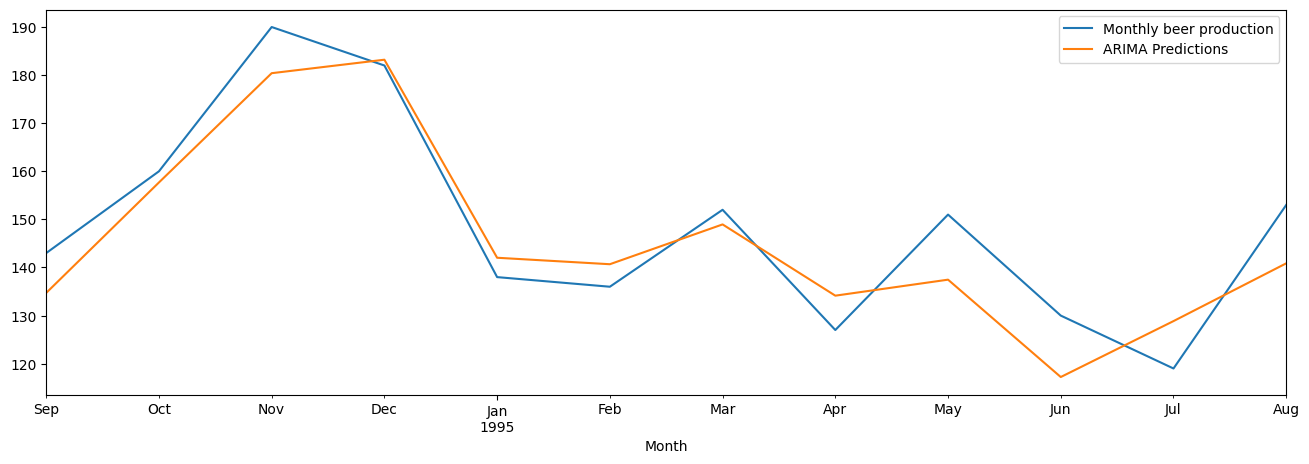

In [ ]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

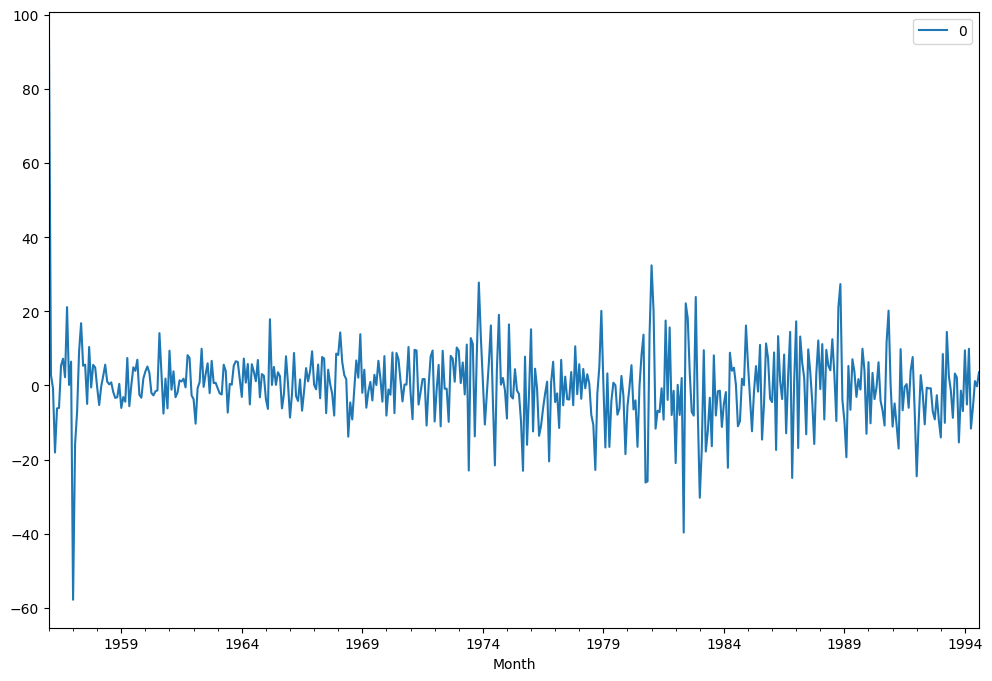

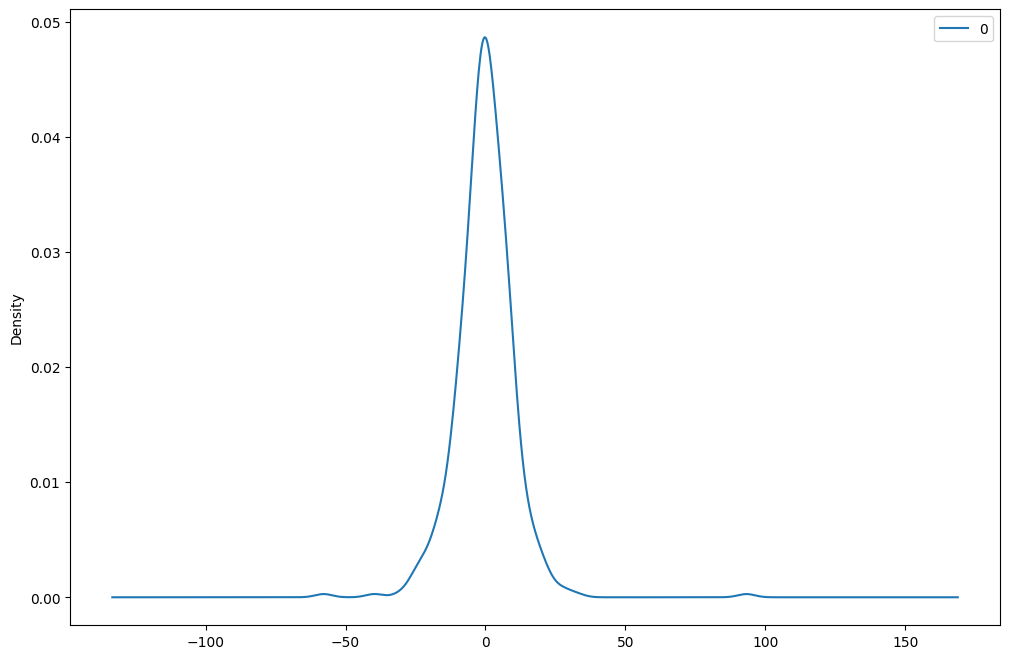

                0
count  464.000000
mean    -0.151317
std     10.493731
min    -57.801364
25%     -5.169104
50%      0.077228
75%      5.510795
max     93.200000


In [ ]:
# line plot of residuals
residuals = DataFrame(arima_result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


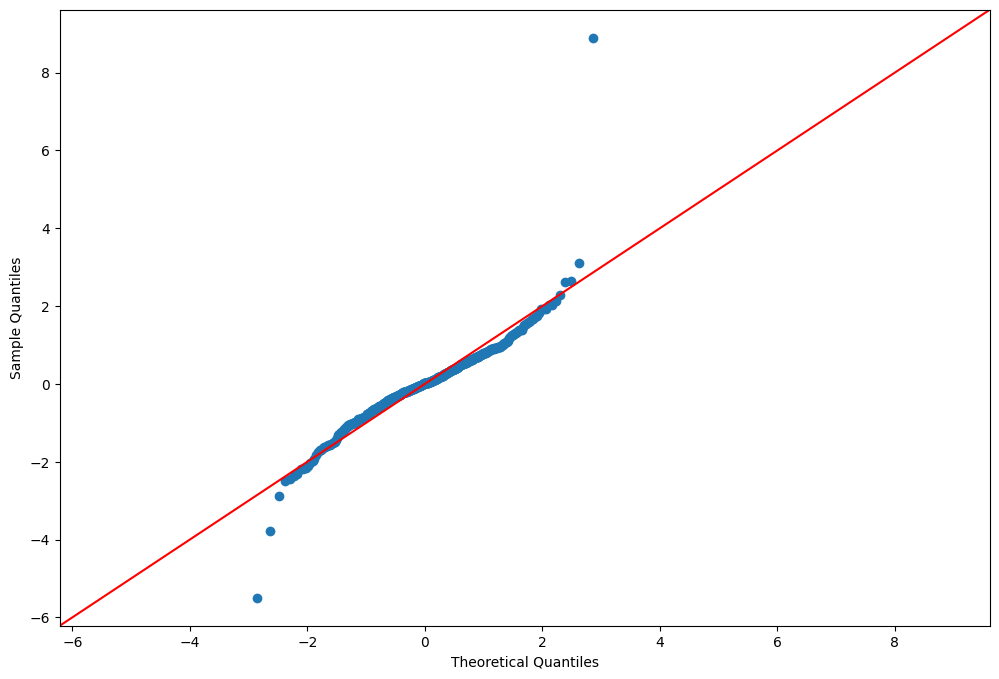

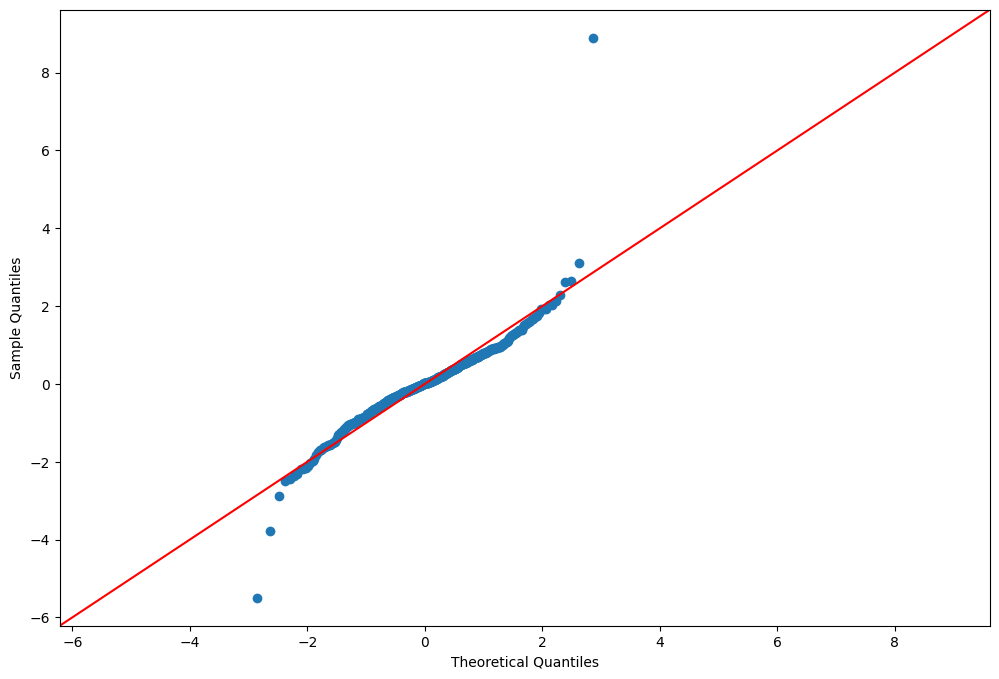

In [ ]:
import statsmodels.api as sm

resid = arima_result.resid
sm.qqplot((resid-resid.mean())/resid.std(), line="45")

# **ITERACION CON SERIE ESTACIONARIA**

# **RED NEURONAL LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df["Monthly beer production"].values.reshape(-1, 1))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : (i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Longitud de la secuencia
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10000, batch_size=32)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 11ms/step - loss: 1.6923e-04
Epoch 7502/10000
12/12 [==============================] - 0s 11ms/step - loss: 1.9695e-04
Epoch 7503/10000
12/12 [==============================] - 0s 11ms/step - loss: 1.8175e-04
Epoch 7504/10000
12/12 [==============================] - 0s 11ms/step - loss: 1.7534e-04
Epoch 7505/10000
12/12 [==============================] - 0s 11ms/step - loss: 1.7361e-04
Epoch 7506/10000
12/12 [==============================] - 0s 10ms/step - loss: 1.7230e-04
Epoch 7507/10000
12/12 [==============================] - 0s 10ms/step - loss: 2.3149e-04
Epoch 7508/10000
12/12 [==============================] - 0s 10ms/step - loss: 1.9944e-04
Epoch 7509/10000
12/12 [==============================] - 0s 11ms/step - loss: 2.1098e-04
Epoch 7510/10000
12/12 [==============================] - 0s 11ms/step - loss: 2.4049e-04
Epoch 7511/10000
12/12 [==============================] - 0s 11ms/

# 300 EPOCHS

3/3 [==============================] - 0s 6ms/step


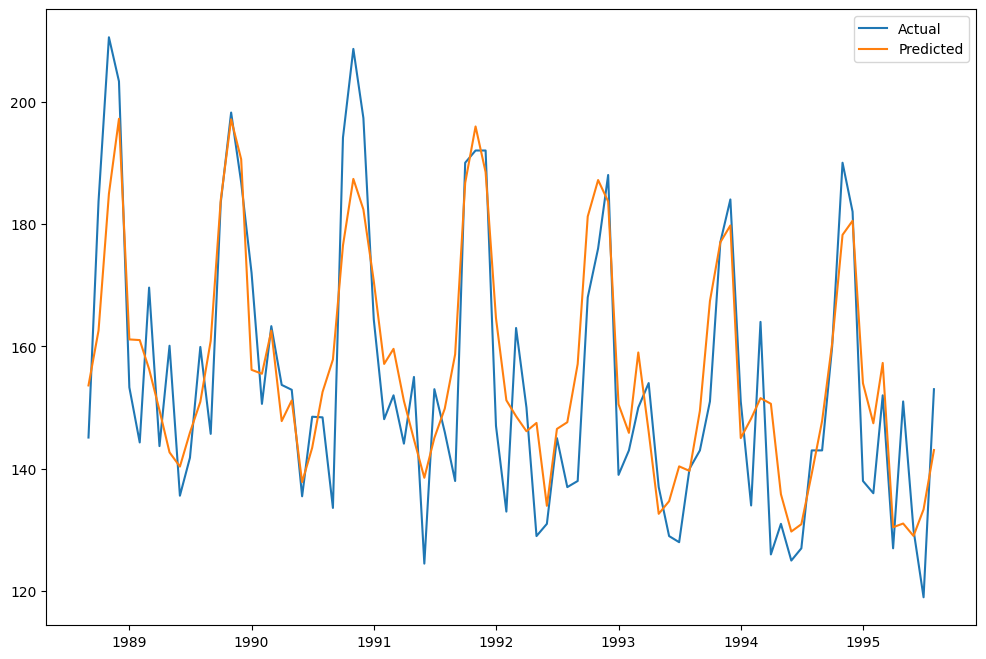

Root Mean Squared Error (RMSE): 11.254791811763504


In [ ]:
# Predecir sobre los datos de prueba
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Deshacer la normalización

# Graficar las predicciones vs los datos reales
plt.plot(df.index[train_size + seq_length:], df["Monthly beer production"][train_size + seq_length:], label='Actual')
plt.plot(df.index[train_size + seq_length:], predictions, label='Predicted')
plt.legend()
plt.show()

# Calcular el error RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df["Monthly beer production"][train_size + seq_length:], predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

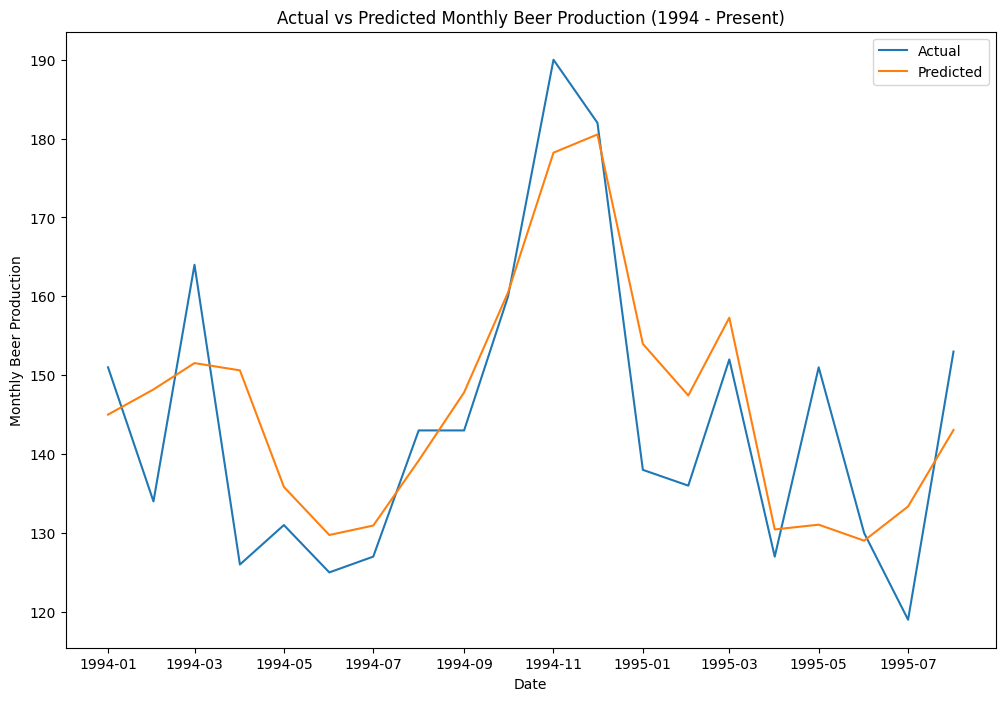

Root Mean Squared Error (RMSE) for data since 1994: 10.88308616297397


In [ ]:
# Filtrar los datos desde 1994 en adelante
df_1994_onwards = df[df.index >= '1994-01-01']

# Graficar las predicciones vs los datos reales desde 1994
plt.plot(df_1994_onwards.index, df_1994_onwards["Monthly beer production"], label='Actual')
plt.plot(df_1994_onwards.index, predictions[-len(df_1994_onwards):], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Monthly Beer Production')
plt.title('Actual vs Predicted Monthly Beer Production (1994 - Present)')
plt.legend()
plt.show()

# Calcular el error RMSE solo para los datos desde 1994
actual_data_1994 = df_1994_onwards["Monthly beer production"]
predicted_data_1994 = predictions[-len(df_1994_onwards):]
rmse_1994 = np.sqrt(mean_squared_error(actual_data_1994, predicted_data_1994))
print(f'Root Mean Squared Error (RMSE) for data since 1994: {rmse_1994}')

# 1000 EPOCHS

3/3 [==============================] - 0s 8ms/step


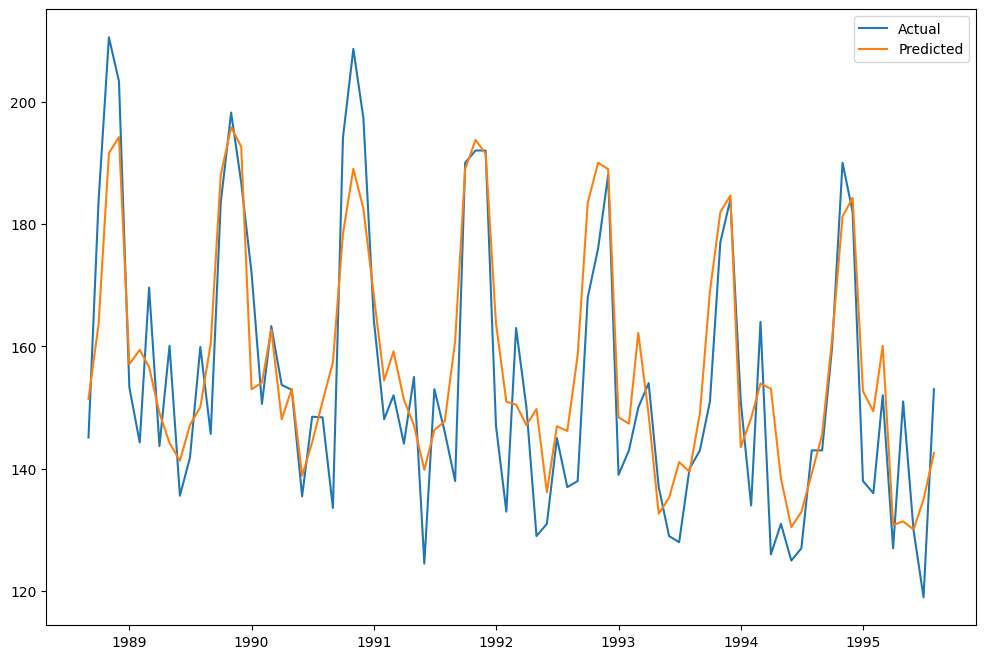

Root Mean Squared Error (RMSE): 11.189253117346691


In [ ]:
# Predecir sobre los datos de prueba
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Deshacer la normalización

# Graficar las predicciones vs los datos reales
plt.plot(df.index[train_size + seq_length:], df["Monthly beer production"][train_size + seq_length:], label='Actual')
plt.plot(df.index[train_size + seq_length:], predictions, label='Predicted')
plt.legend()
plt.show()

# Calcular el error RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df["Monthly beer production"][train_size + seq_length:], predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

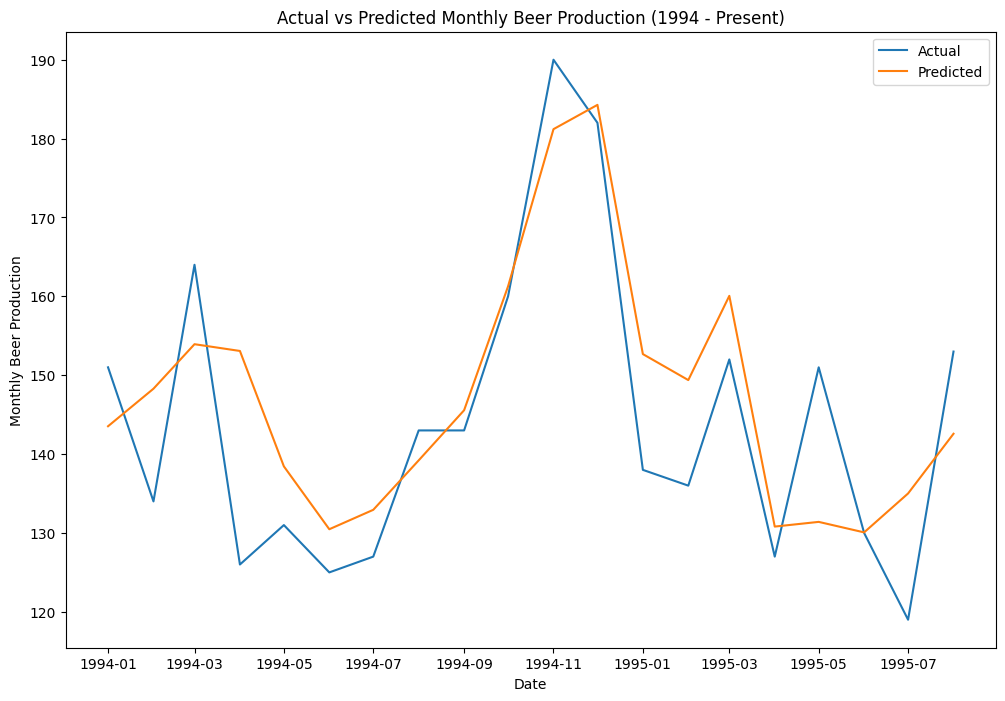

Root Mean Squared Error (RMSE) for data since 1994: 11.276278036287854


In [ ]:
# Filtrar los datos desde 1994 en adelante
df_1994_onwards = df[df.index >= '1994-01-01']

# Graficar las predicciones vs los datos reales desde 1994
plt.plot(df_1994_onwards.index, df_1994_onwards["Monthly beer production"], label='Actual')
plt.plot(df_1994_onwards.index, predictions[-len(df_1994_onwards):], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Monthly Beer Production')
plt.title('Actual vs Predicted Monthly Beer Production (1994 - Present)')
plt.legend()
plt.show()

# Calcular el error RMSE solo para los datos desde 1994
actual_data_1994 = df_1994_onwards["Monthly beer production"]
predicted_data_1994 = predictions[-len(df_1994_onwards):]
rmse_1994 = np.sqrt(mean_squared_error(actual_data_1994, predicted_data_1994))
print(f'Root Mean Squared Error (RMSE) for data since 1994: {rmse_1994}')

Podemos ver que tanto en la prediccion de el LSTM y de SARIMAX el dato mejor predicho es el de marzo del 95, esto no nos dice mucho pero me resulto interesante. Hay que hacer ahora un analsis de error entre prediccion y valor real para ambos metodos y asi realizar una mejor conclusion sobre los resultados obtenidos.

# 10000 EPOCHS

3/3 [==============================] - 0s 7ms/step


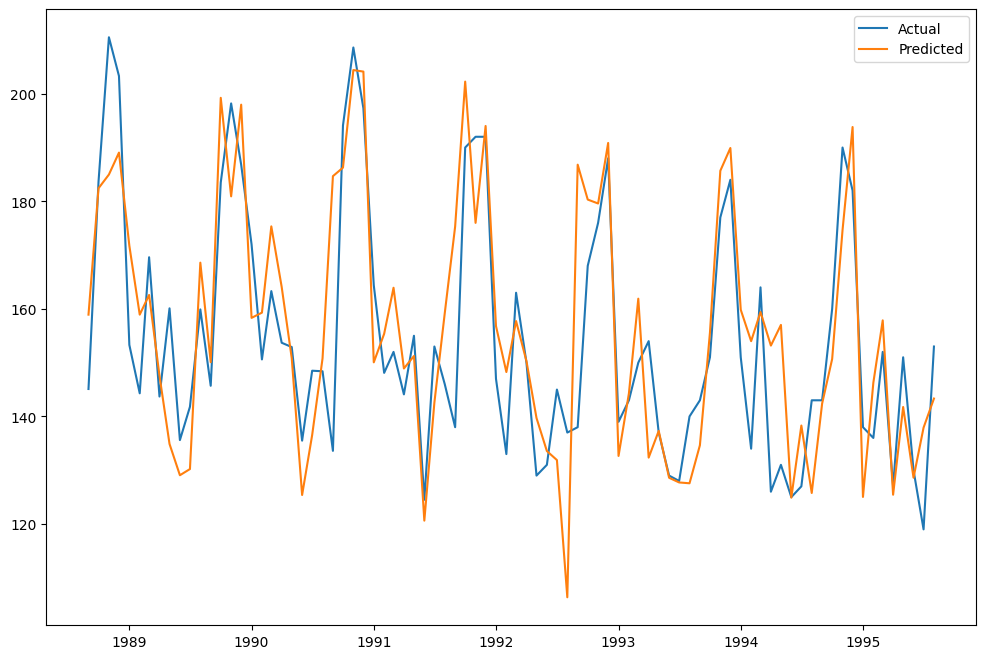

Root Mean Squared Error (RMSE): 14.674723897417335


In [ ]:
# Predecir sobre los datos de prueba
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Deshacer la normalización

# Graficar las predicciones vs los datos reales
plt.plot(df.index[train_size + seq_length:], df["Monthly beer production"][train_size + seq_length:], label='Actual')
plt.plot(df.index[train_size + seq_length:], predictions, label='Predicted')
plt.legend()
plt.show()

# Calcular el error RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df["Monthly beer production"][train_size + seq_length:], predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

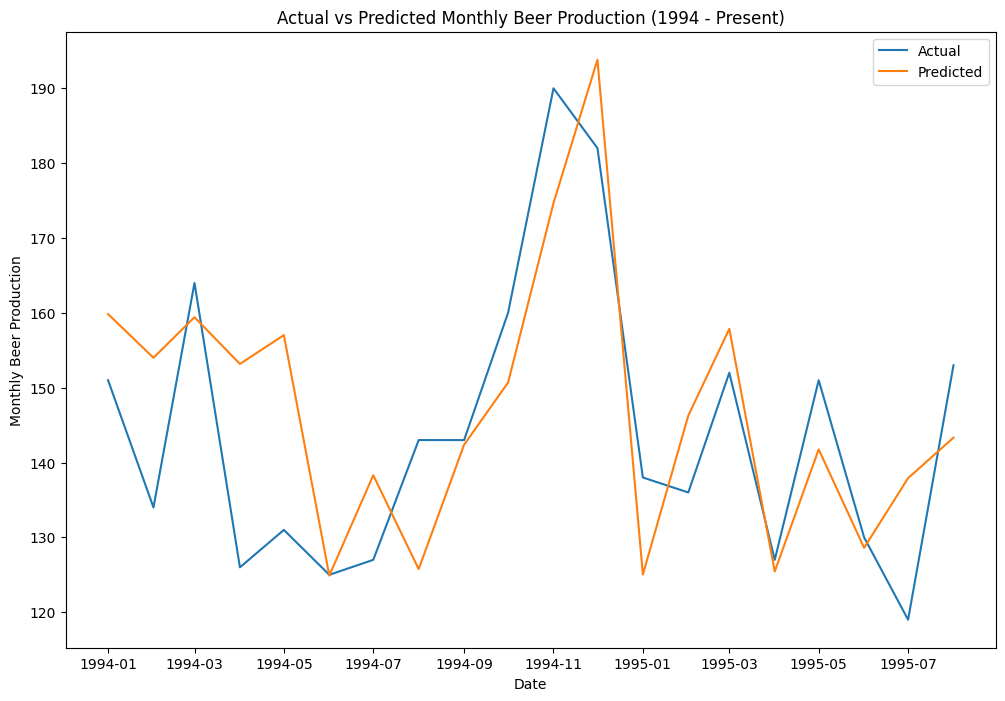

Root Mean Squared Error (RMSE) for data since 1994: 13.510389531886162


In [ ]:
# Filtrar los datos desde 1994 en adelante
df_1994_onwards = df[df.index >= '1994-01-01']

# Graficar las predicciones vs los datos reales desde 1994
plt.plot(df_1994_onwards.index, df_1994_onwards["Monthly beer production"], label='Actual')
plt.plot(df_1994_onwards.index, predictions[-len(df_1994_onwards):], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Monthly Beer Production')
plt.title('Actual vs Predicted Monthly Beer Production (1994 - Present)')
plt.legend()
plt.show()

# Calcular el error RMSE solo para los datos desde 1994
actual_data_1994 = df_1994_onwards["Monthly beer production"]
predicted_data_1994 = predictions[-len(df_1994_onwards):]
rmse_1994 = np.sqrt(mean_squared_error(actual_data_1994, predicted_data_1994))
print(f'Root Mean Squared Error (RMSE) for data since 1994: {rmse_1994}')

# Analisis espectral.

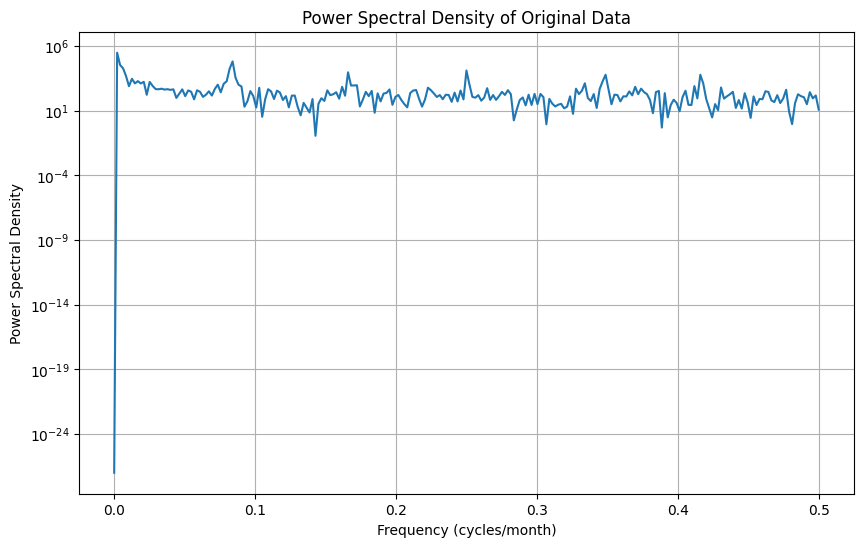

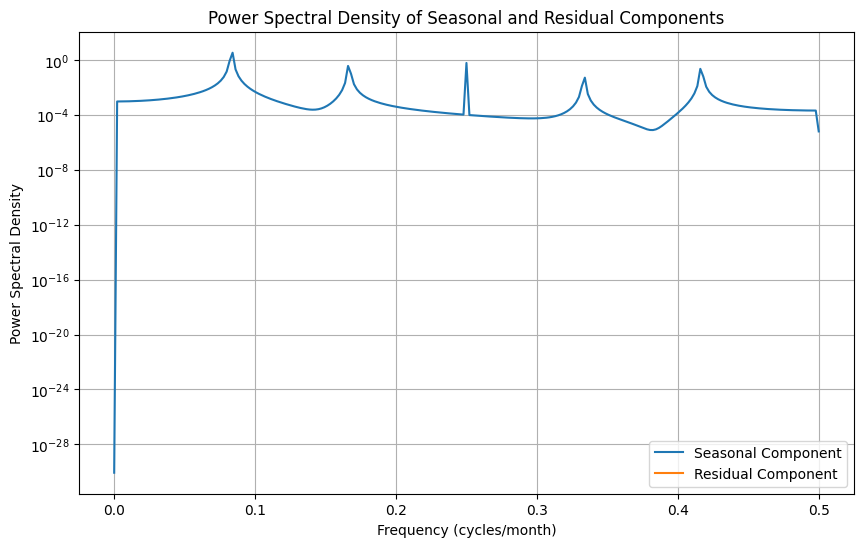

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose

# Análisis espectral del conjunto de datos original
freq_original, psd_original = periodogram(df['Monthly beer production'])

# Graficar el espectro de potencia
plt.figure(figsize=(10, 6))
plt.semilogy(freq_original, psd_original)
plt.xlabel('Frequency (cycles/month)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Original Data')
plt.grid(True)
plt.show()

# Descomposición en componentes cíclicas y estacionales
decomposition = seasonal_decompose(df['Monthly beer production'], model='multiplicative', period=12)

# Análisis espectral de la componente estacional
freq_seasonal, psd_seasonal = periodogram(decomposition.seasonal)

# Análisis espectral de la componente residual
freq_residual, psd_residual = periodogram(decomposition.resid)

# Graficar el espectro de potencia de la componente estacional y residual
plt.figure(figsize=(10, 6))
plt.semilogy(freq_seasonal, psd_seasonal, label='Seasonal Component')
plt.semilogy(freq_residual, psd_residual, label='Residual Component')
plt.xlabel('Frequency (cycles/month)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Seasonal and Residual Components')
plt.legend()
plt.grid(True)
plt.show()


* En el eje x (frecuencia), se representa la frecuencia de ciclos por unidad de tiempo. En este caso, "cycles/month" indica la cantidad de ciclos que ocurren en un mes.
* En el eje y (densidad espectral de potencia), se representa la intensidad de las diferentes frecuencias presentes en el conjunto de datos original.
* Un pico en el espectro de potencia indica una frecuencia dominante en los datos. Por ejemplo, hay un pico en 0.08 cycles/month, significa que hay una variación que se repite cada 8 meses en promedio.

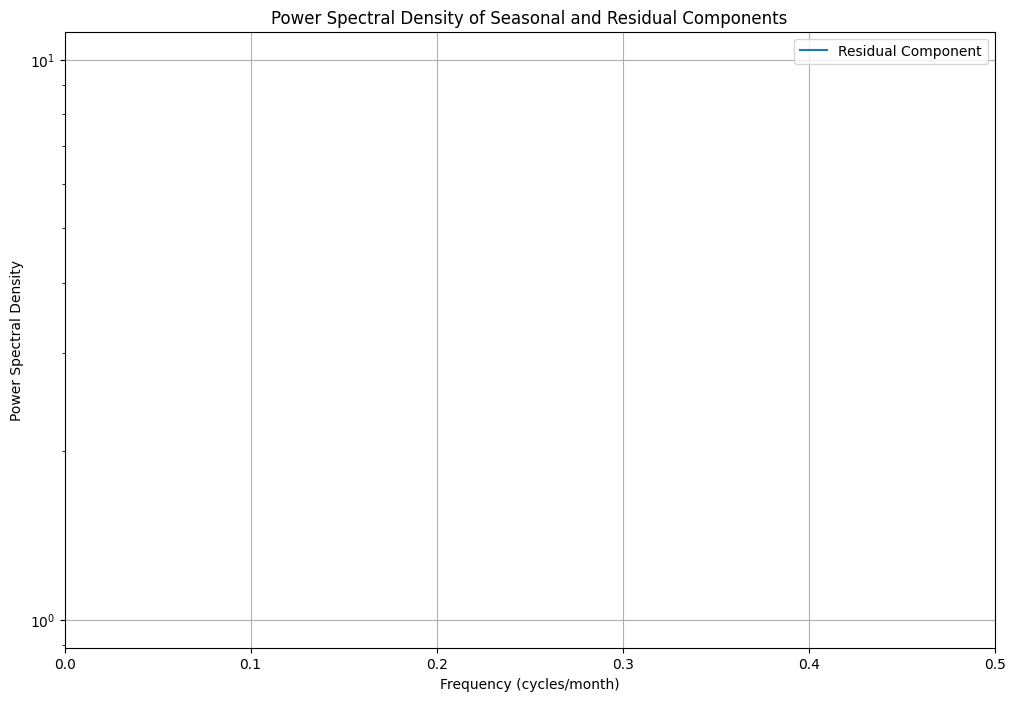

In [ ]:
#plt.semilogy(freq_seasonal, psd_seasonal, label='Seasonal Component')
plt.semilogy(freq_residual, psd_residual, label='Residual Component')
plt.xlim(0, 0.5)  # Ajustar el rango de frecuencias para visualizar mejor la componente estacional
plt.xlabel('Frequency (cycles/month)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of Seasonal and Residual Components')
plt.legend()
plt.grid(True)
plt.show()


Si el componente residual no muestra componentes cíclicas significativas en su espectro de potencia, puede indicar que esta variabilidad no sigue patrones repetitivos discernibles y es más bien aleatoria o compleja en naturaleza.

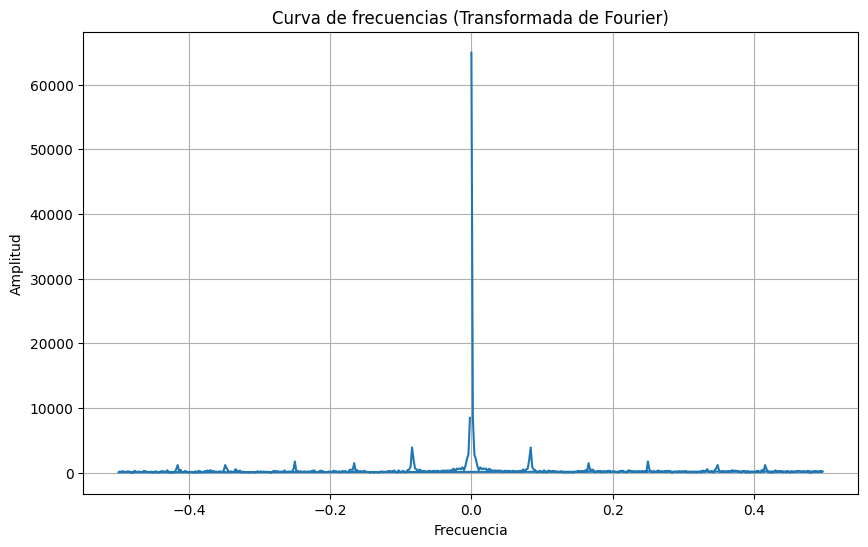

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Series Temporales/monthly-beer-production-in-austr.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])

# Obtener la serie de tiempo (suponiendo que es mensual)
time_series = df['Monthly beer production'].values

# Aplicar la transformada de Fourier
fourier_transform = np.fft.fft(time_series)
frequencies = np.fft.fftfreq(len(time_series))

# Graficar la curva de frecuencias
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fourier_transform))
plt.title('Curva de frecuencias (Transformada de Fourier)')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()



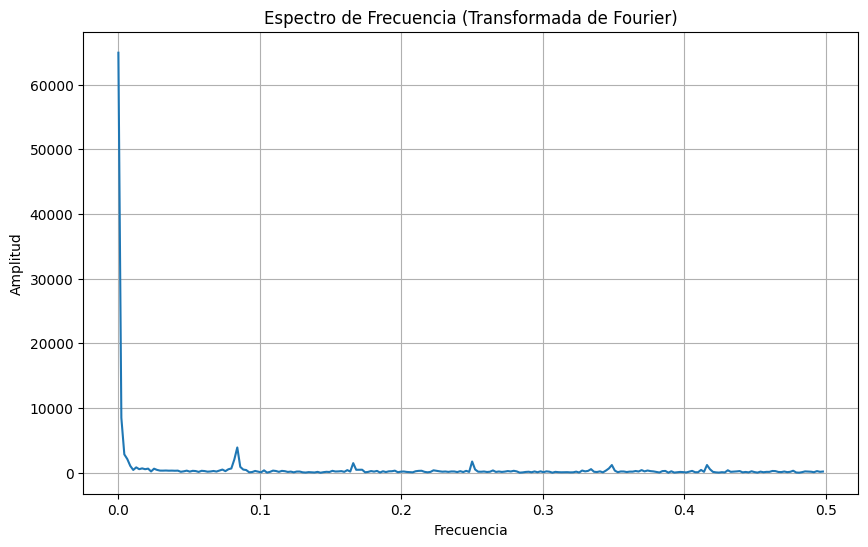

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Obtener la serie de tiempo
time_series = df['Monthly beer production'].values

# Calcular la Transformada de Fourier
fourier_transform = np.fft.fft(time_series)
frequencies = np.fft.fftfreq(len(time_series))

# Graficar el espectro de frecuencia
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fourier_transform)[:len(frequencies)//2])
plt.title('Espectro de Frecuencia (Transformada de Fourier)')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()



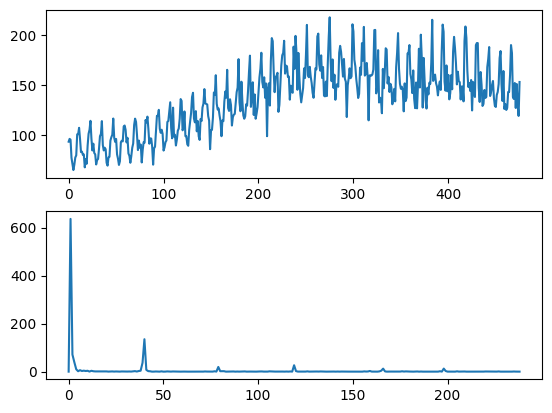

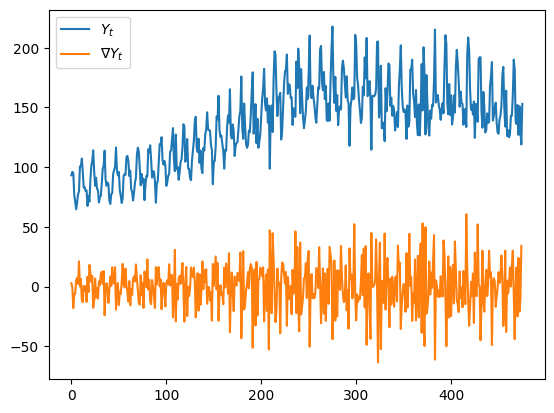

In [ ]:
import pandas as pd
from scipy import signal

Y=df['Monthly beer production'].values
N=int(len(Y))

G, Pyy_den = signal.periodogram(Y,N)
plt.subplot(2,1,1)
plt.plot(Y)
plt.subplot(2,1,2)
plt.plot(G, Pyy_den)
plt.show()

dataset=Y
interval=1
diff = list()
for i in range(interval, len(dataset)):
	value = dataset[i] - dataset[i - interval]
	diff.append(value)

plt.plot(Y)
plt.plot(diff)
plt.legend(['$Y_t$','$\\nabla Y_t$'])
plt.show()

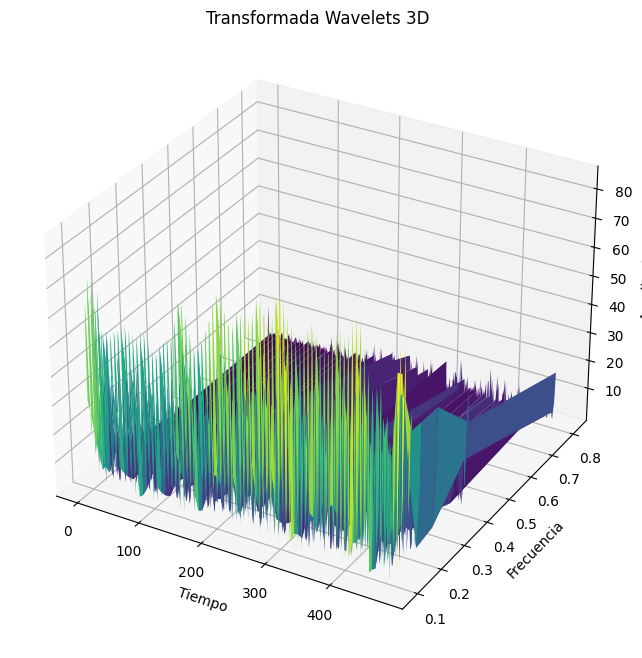

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Obtener la serie de tiempo
time_series = df['Monthly beer production'].values

# Realizar la transformada wavelets
wavelet = 'morl'  # Wavelet a utilizar (en este caso, Morlet)
coefficients, frequencies = pywt.cwt(time_series, scales=np.arange(1, 10), wavelet=wavelet)

# Graficar en 3D: tiempo, frecuencia y amplitud
t = np.arange(len(time_series))
T, F = np.meshgrid(t, frequencies)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, F, np.abs(coefficients), cmap='viridis')
ax.set_title('Transformada Wavelets 3D')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Frecuencia')
ax.set_zlabel('Amplitud')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import pywt

# Obtener la serie de tiempo
time_series = df['Monthly beer production'].values

# Realizar la transformada wavelets
wavelet = 'morl'  # Wavelet a utilizar (en este caso, Morlet)
coefficients, frequencies = pywt.cwt(time_series, scales=np.arange(1, 10), wavelet=wavelet)

# Preparar los datos para Plotly Express
t = np.arange(len(time_series))
T, F = np.meshgrid(t, frequencies)
data = {
    'T': T.flatten(),
    'F': F.flatten(),
    'Amplitud': np.abs(coefficients).flatten()
}
df_plot = pd.DataFrame(data)

# Graficar en 3D con Plotly Express
fig = px.scatter_3d(df_plot, x='T', y='F', z='Amplitud', color='Amplitud',
                     labels={'T': 'Tiempo', 'F': 'Frecuencia', 'Amplitud': 'Amplitud'},
                     title='Transformada Wavelets 3D')
fig.update_traces(marker=dict(size=3))
fig.show()



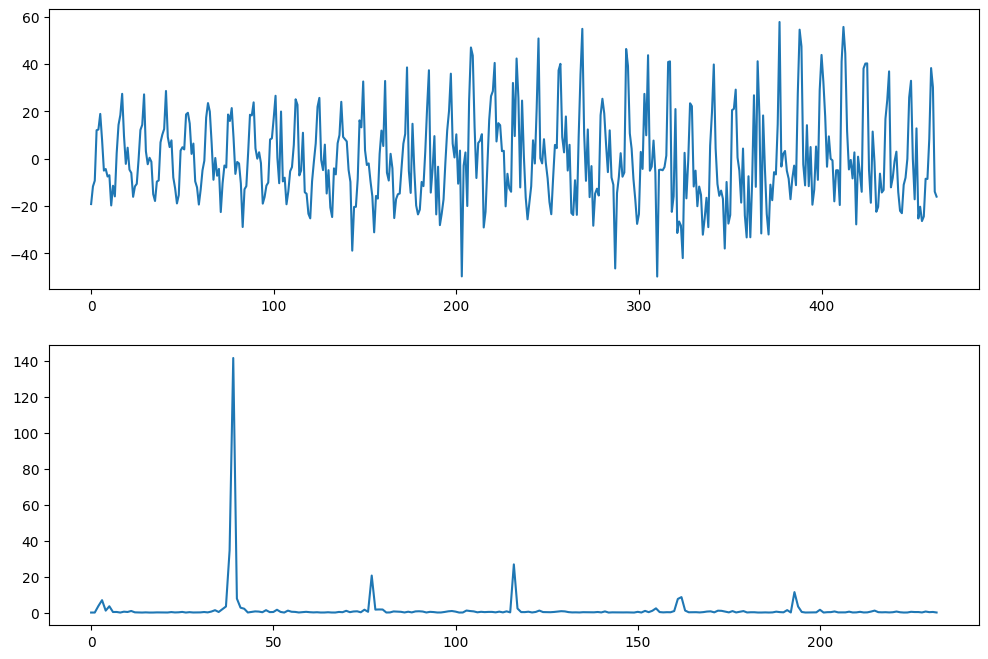

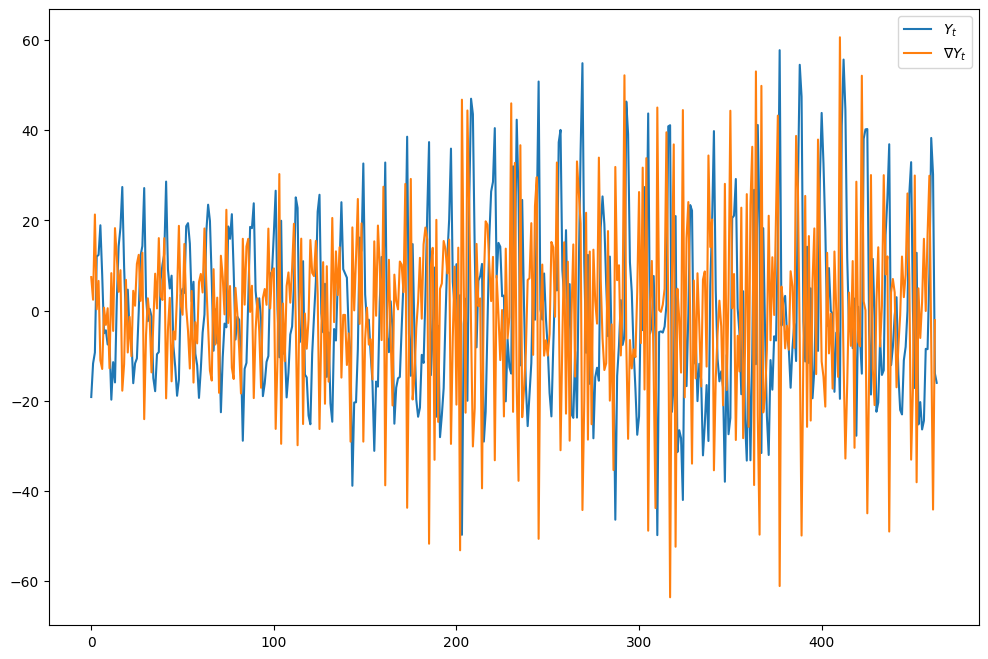

In [ ]:
import pandas as pd
from scipy import signal

Y=stationary_data_cleaned.values
N=int(len(Y))

G, Pyy_den = signal.periodogram(Y,N)
plt.subplot(2,1,1)
plt.plot(Y)
plt.subplot(2,1,2)
plt.plot(G, Pyy_den)
plt.show()

dataset=Y
interval=1
diff = list()
for i in range(interval, len(dataset)):
	value = dataset[i] - dataset[i - interval]
	diff.append(value)

plt.plot(Y)
plt.plot(diff)
plt.legend(['$Y_t$','$\\nabla Y_t$'])
plt.show()

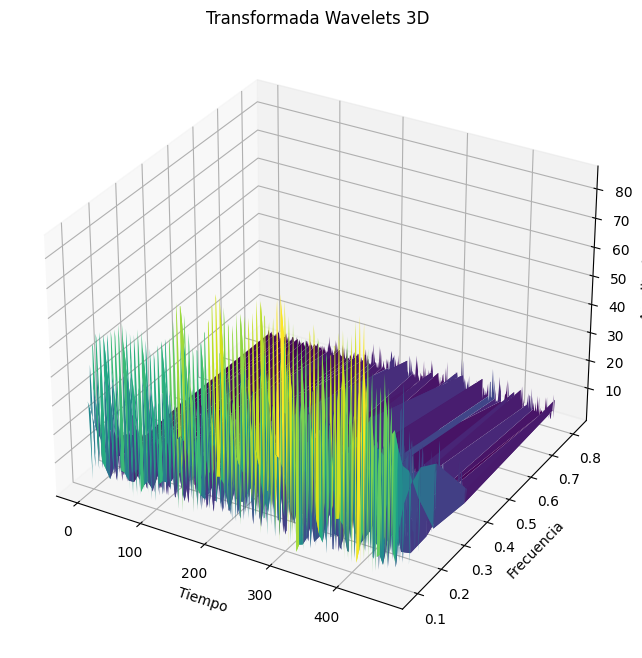

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Obtener la serie de tiempo
time_series = stationary_data_cleaned.values

# Realizar la transformada wavelets
wavelet = 'morl'  # Wavelet a utilizar (en este caso, Morlet)
coefficients, frequencies = pywt.cwt(time_series, scales=np.arange(1, 10), wavelet=wavelet)

# Graficar en 3D: tiempo, frecuencia y amplitud
t = np.arange(len(time_series))
T, F = np.meshgrid(t, frequencies)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, F, np.abs(coefficients), cmap='viridis')
ax.set_title('Transformada Wavelets 3D')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Frecuencia')
ax.set_zlabel('Amplitud')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import pywt

# Obtener la serie de tiempo
time_series = stationary_data_cleaned.values

# Realizar la transformada wavelets
wavelet = 'morl'  # Wavelet a utilizar (en este caso, Morlet)
coefficients, frequencies = pywt.cwt(time_series, scales=np.arange(1, 10), wavelet=wavelet)

# Preparar los datos para Plotly Express
t = np.arange(len(time_series))
T, F = np.meshgrid(t, frequencies)
data = {
    'T': T.flatten(),
    'F': F.flatten(),
    'Amplitud': np.abs(coefficients).flatten()
}
df_plot = pd.DataFrame(data)

# Graficar en 3D con Plotly Express
fig = px.scatter_3d(df_plot, x='T', y='F', z='Amplitud', color='Amplitud',
                     labels={'T': 'Tiempo', 'F': 'Frecuencia', 'Amplitud': 'Amplitud'},
                     title='Transformada Wavelets 3D')
fig.update_traces(marker=dict(size=3))
fig.show()
